# Visualizaci√≥n de Emisiones de CO‚ÇÇ y su Relaci√≥n con Indicadores Econ√≥micos

Este notebook analiza las tendencias globales de emisiones de CO‚ÇÇ y su relaci√≥n con indicadores econ√≥micos como el PIB, explorando patrones y correlaciones a nivel mundial y regional.

## Configuraci√≥n del Entorno

Importamos las bibliotecas necesarias y establecemos la conexi√≥n con la base de datos.

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
import geopandas as gpd
from dotenv import load_dotenv
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import pycountry
# from scipy import stats

# Configuraci√≥n visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Cargar variables de entorno y conectar a la base de datos
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# Funciones de formato para ejes
def formato_millones(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}k'

def formato_miles_millones(x, pos):
    return f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.1f}M'

## 0. Relacion de emisiones de CO2 - PIB en los paises del mundo

En los siguientes mapas regionales podemos observar como es la relacion entre las emisiones de co2 producidas por cada pais en comparacion a su producto interior bruto

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\4292558473.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


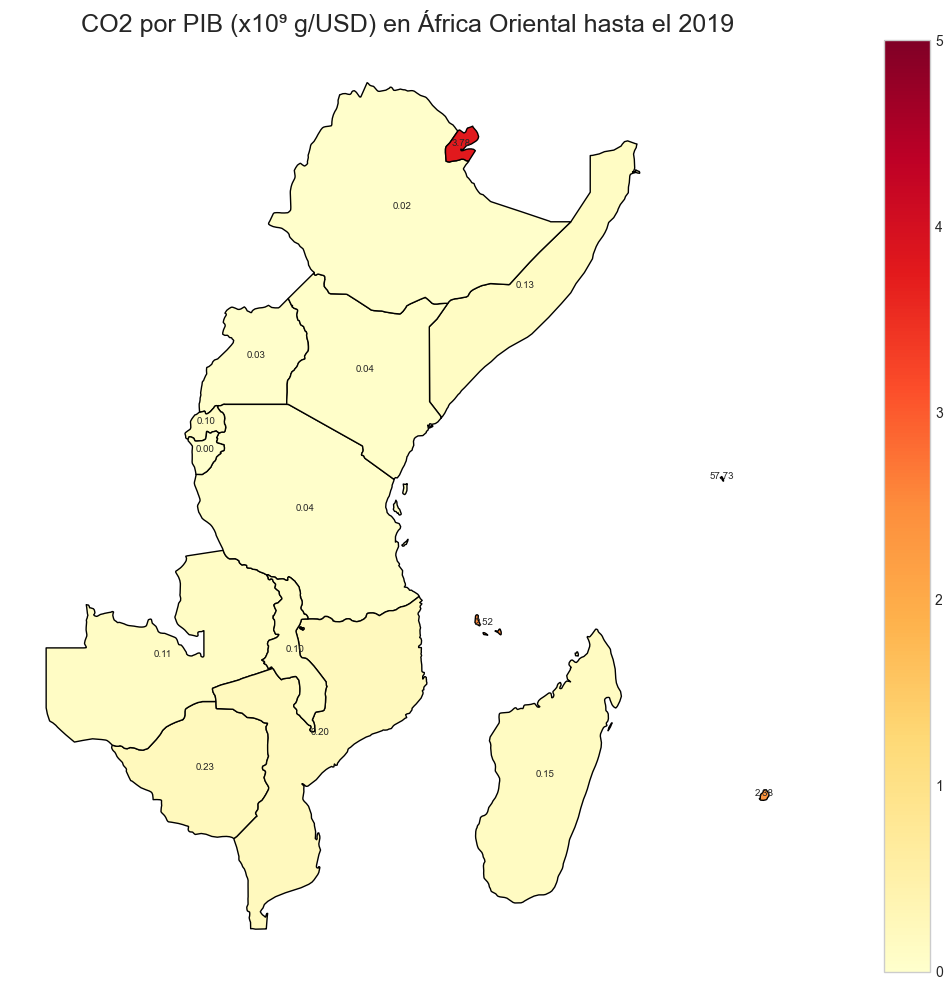

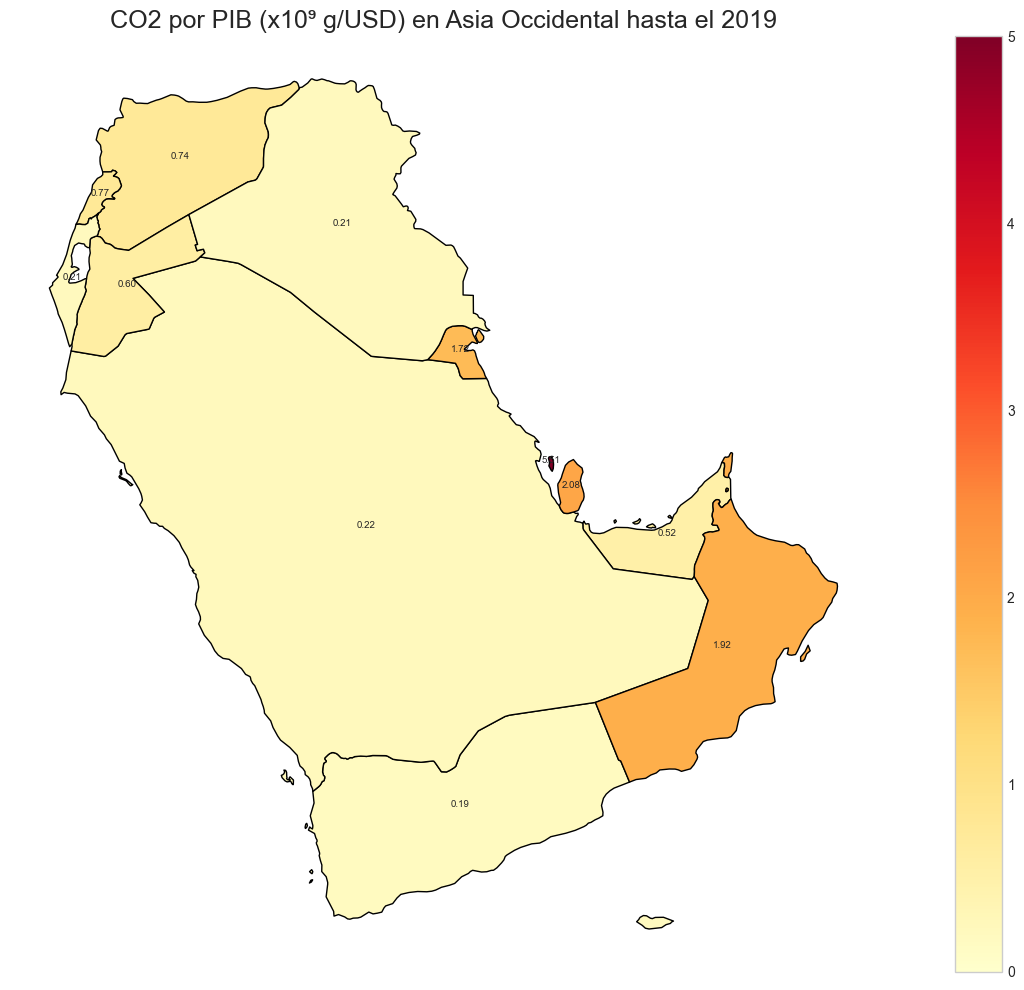

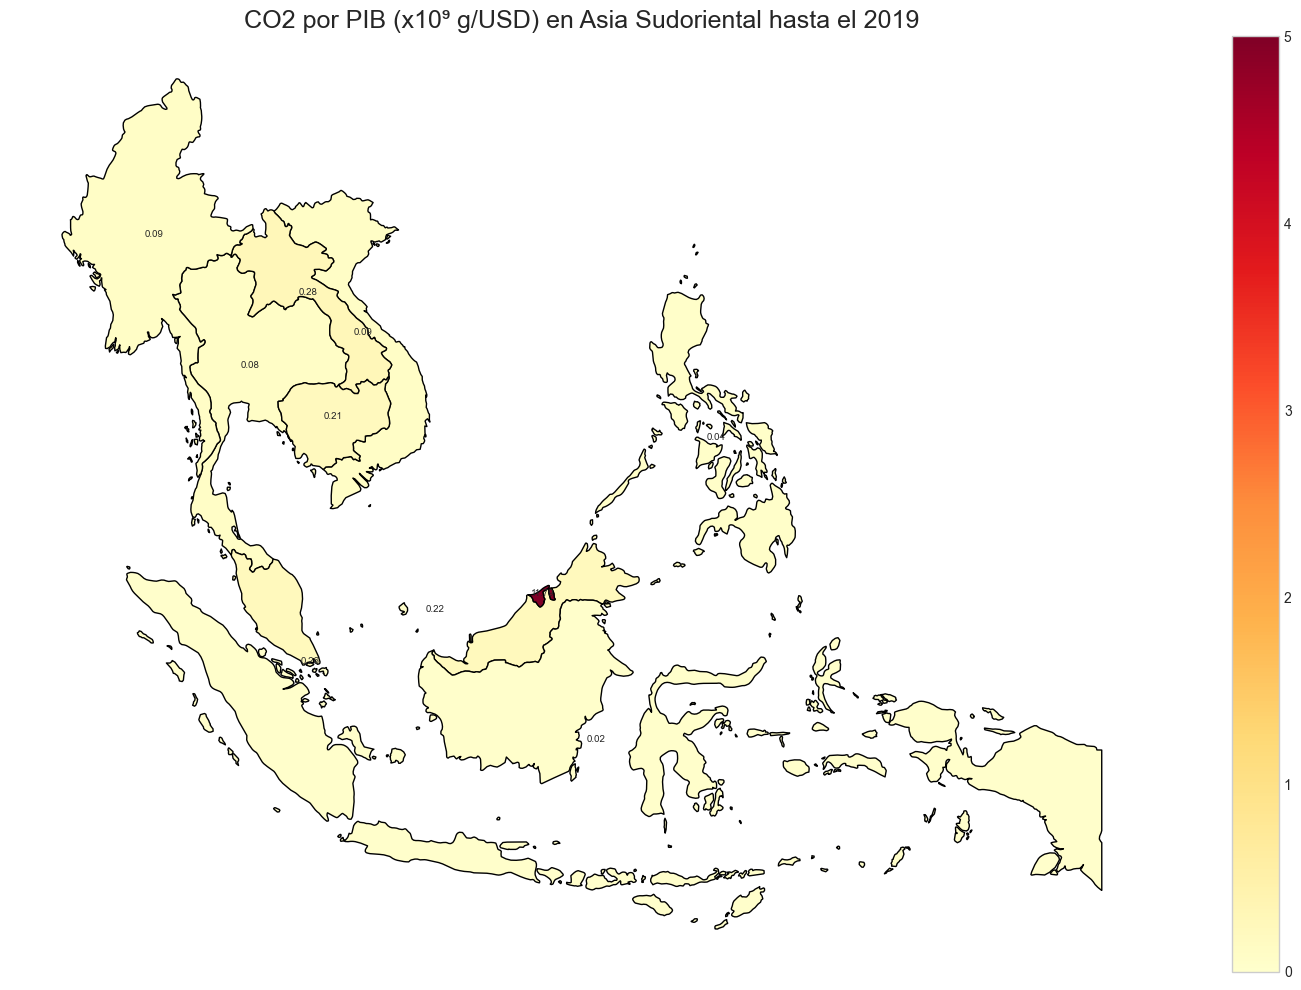

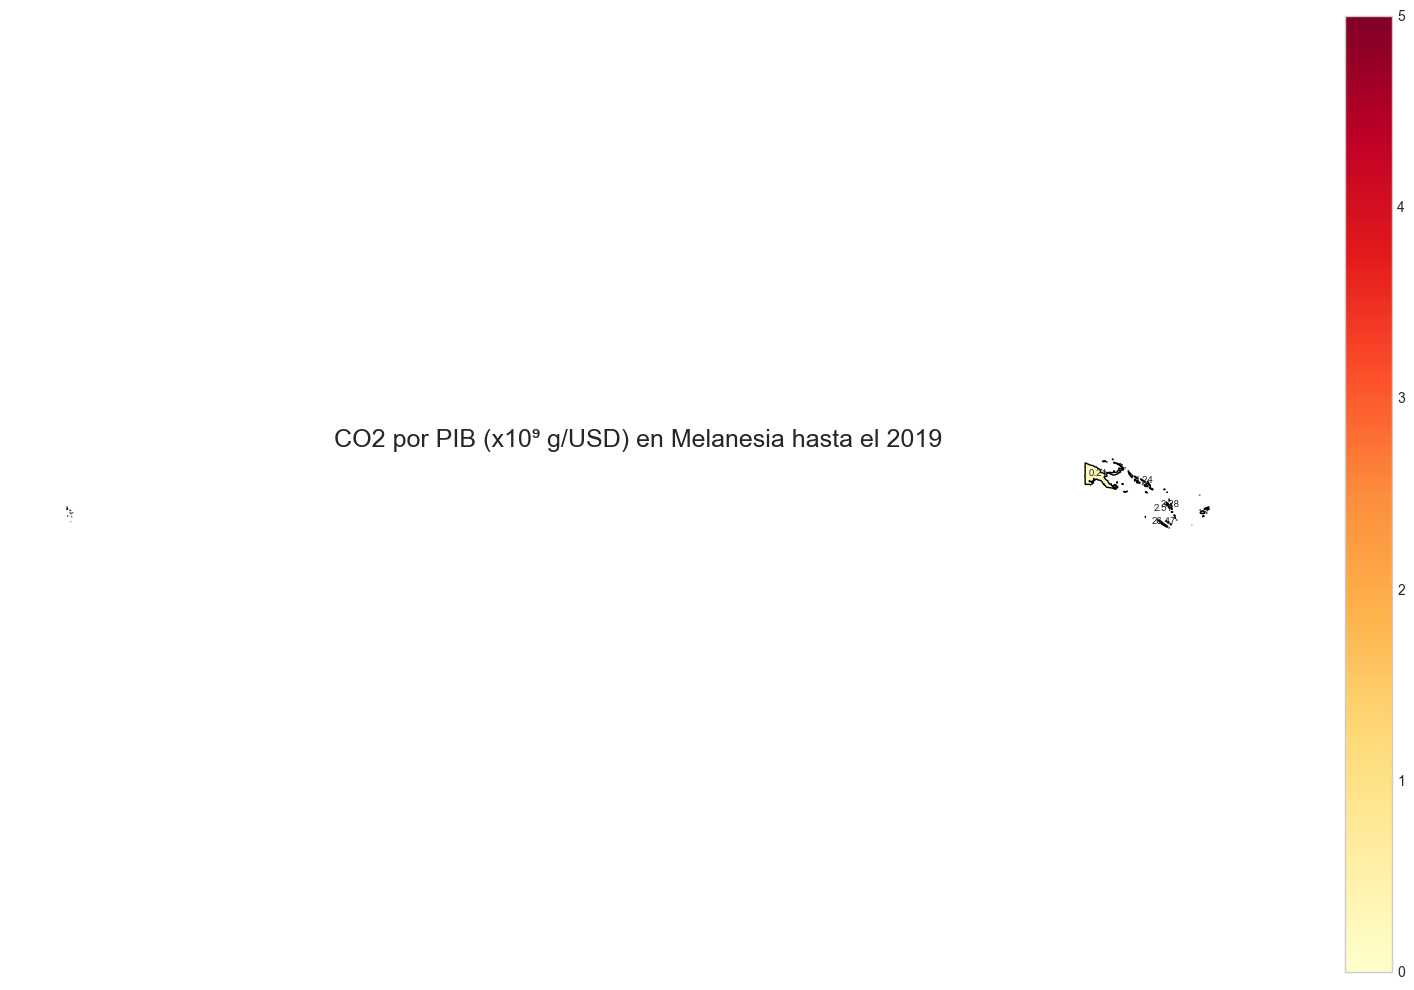

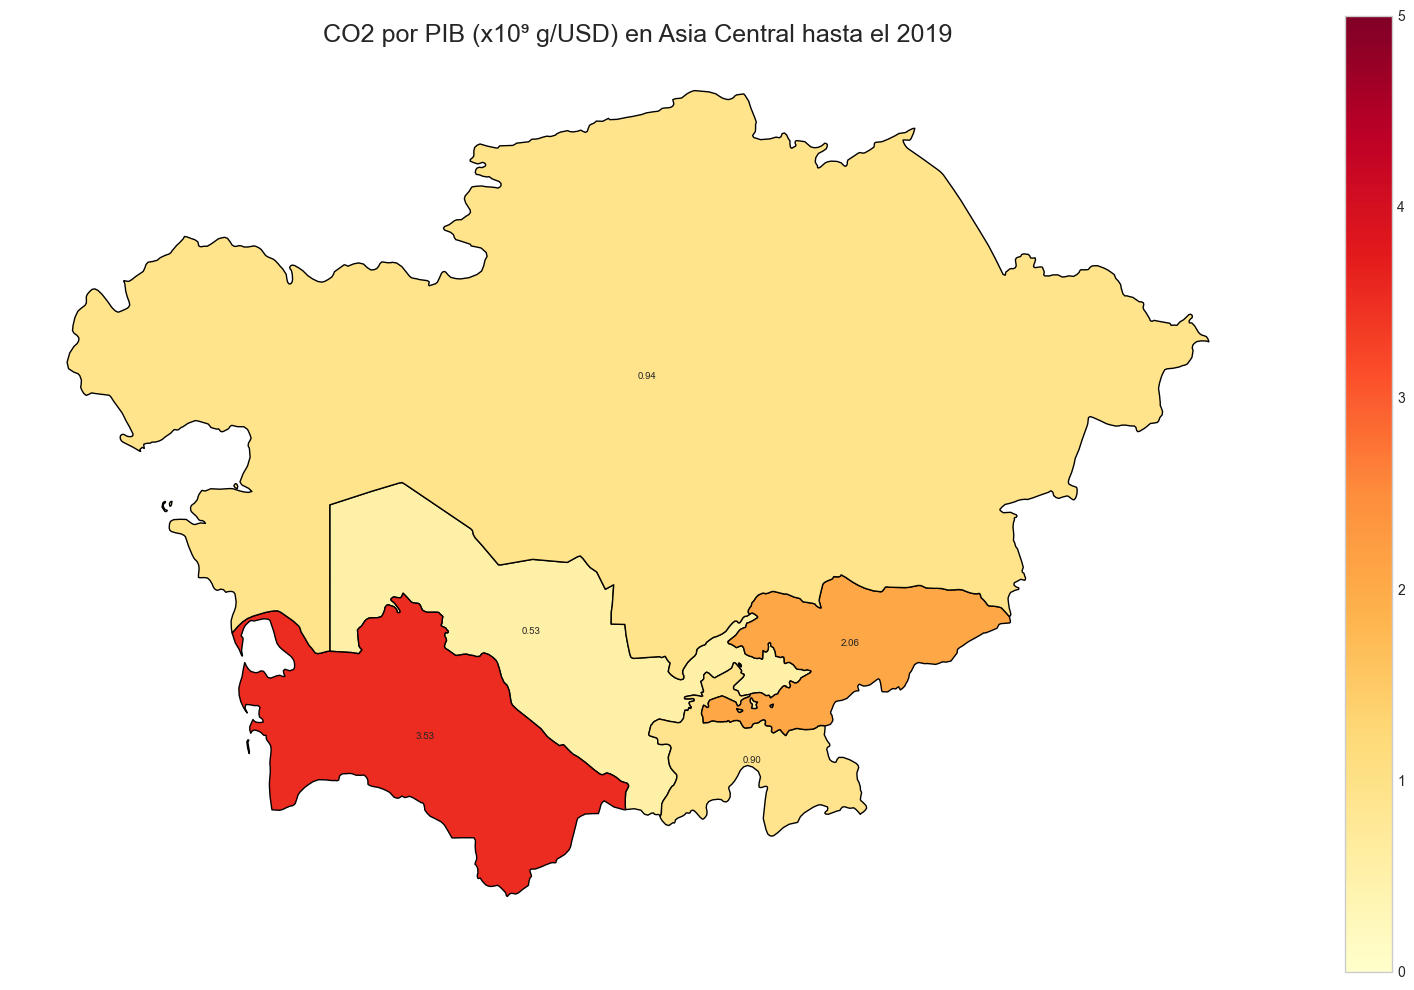

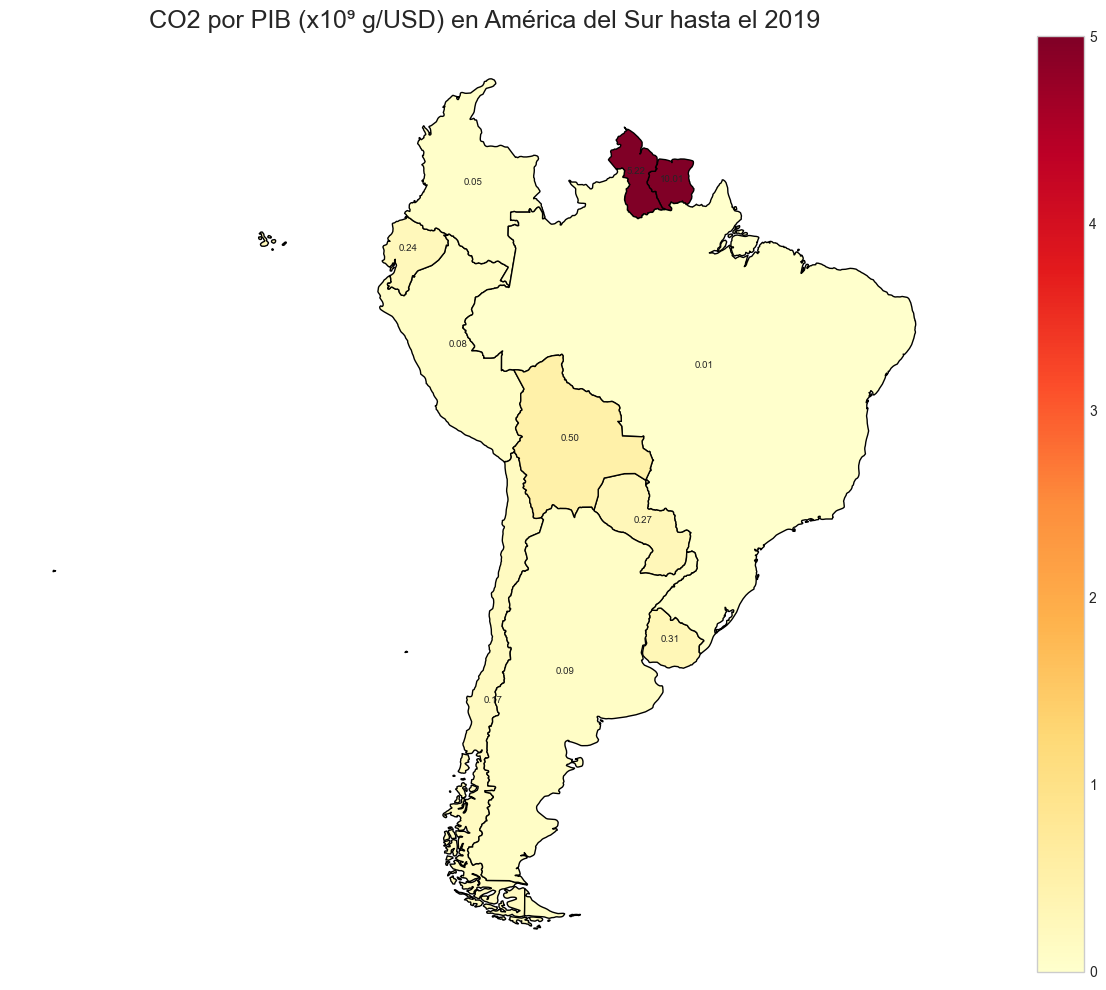

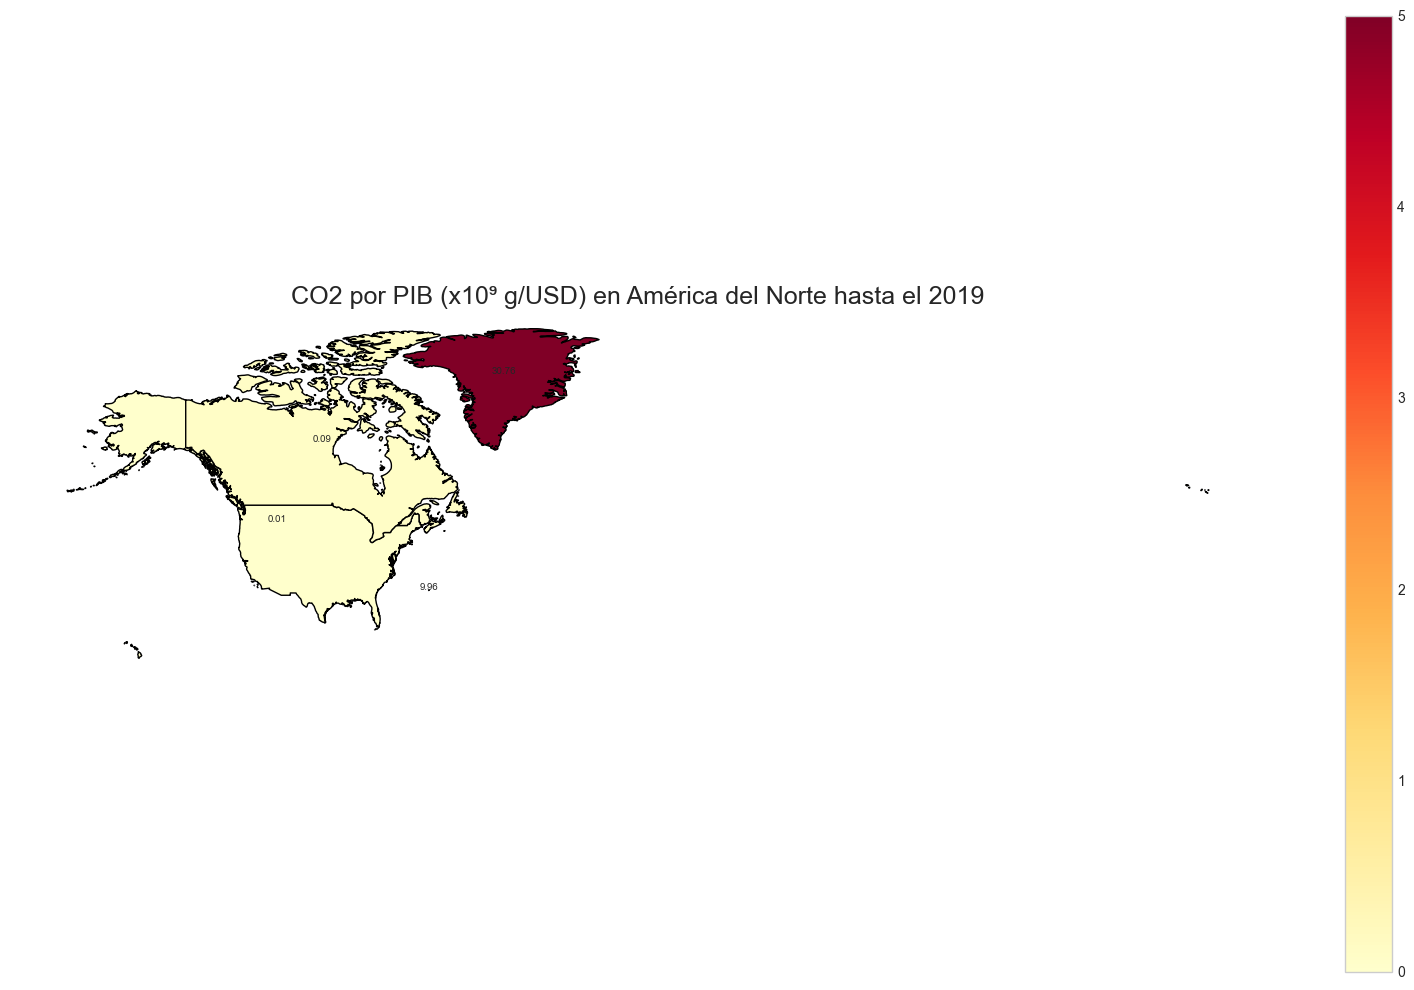

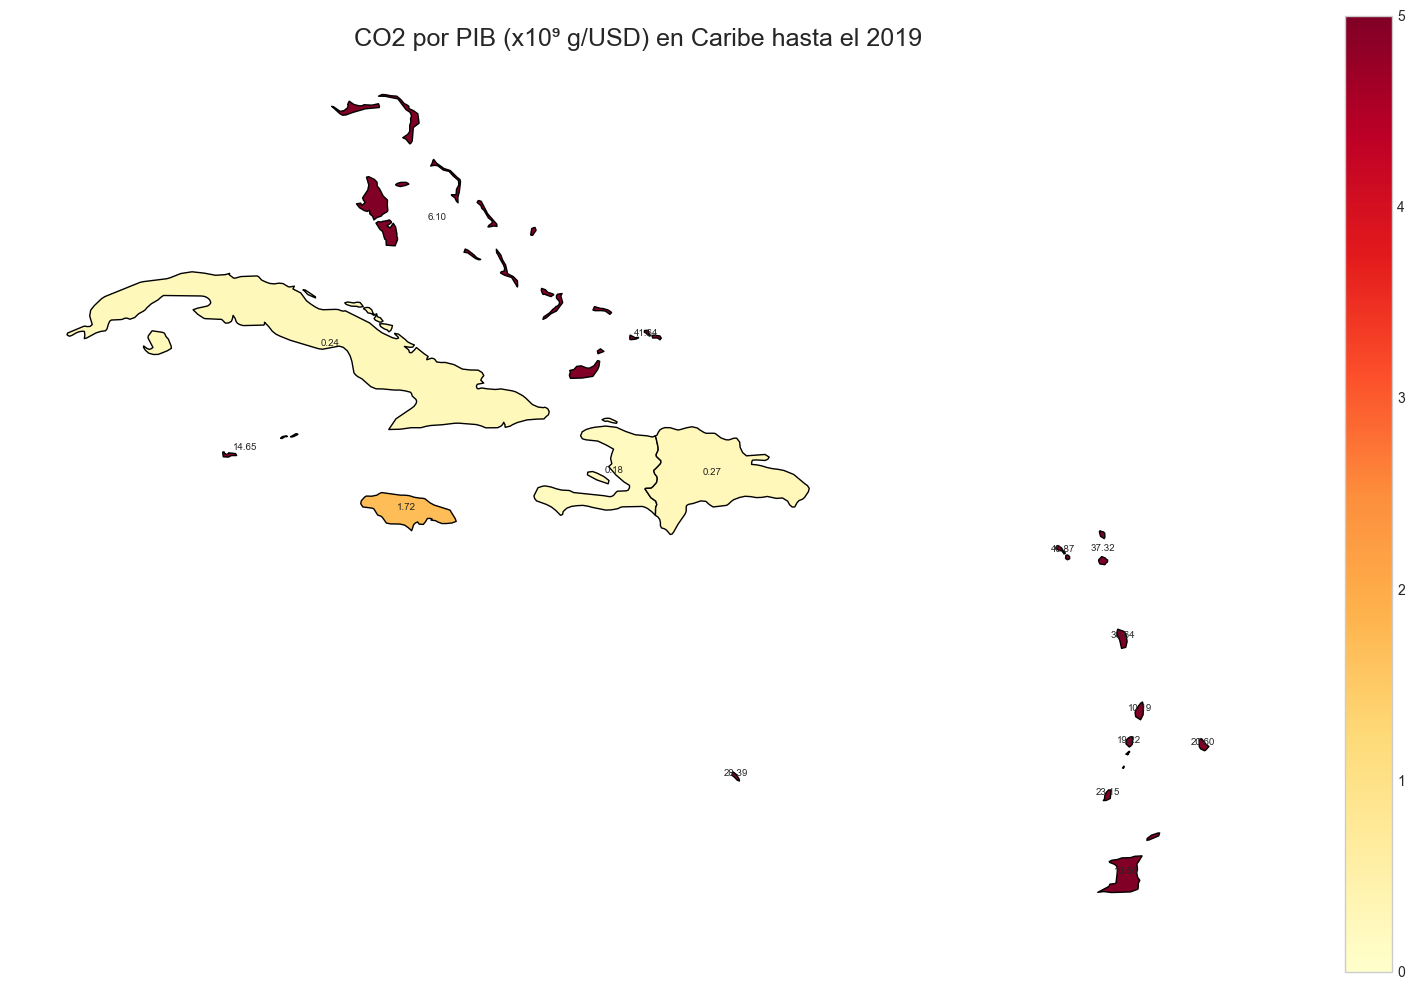

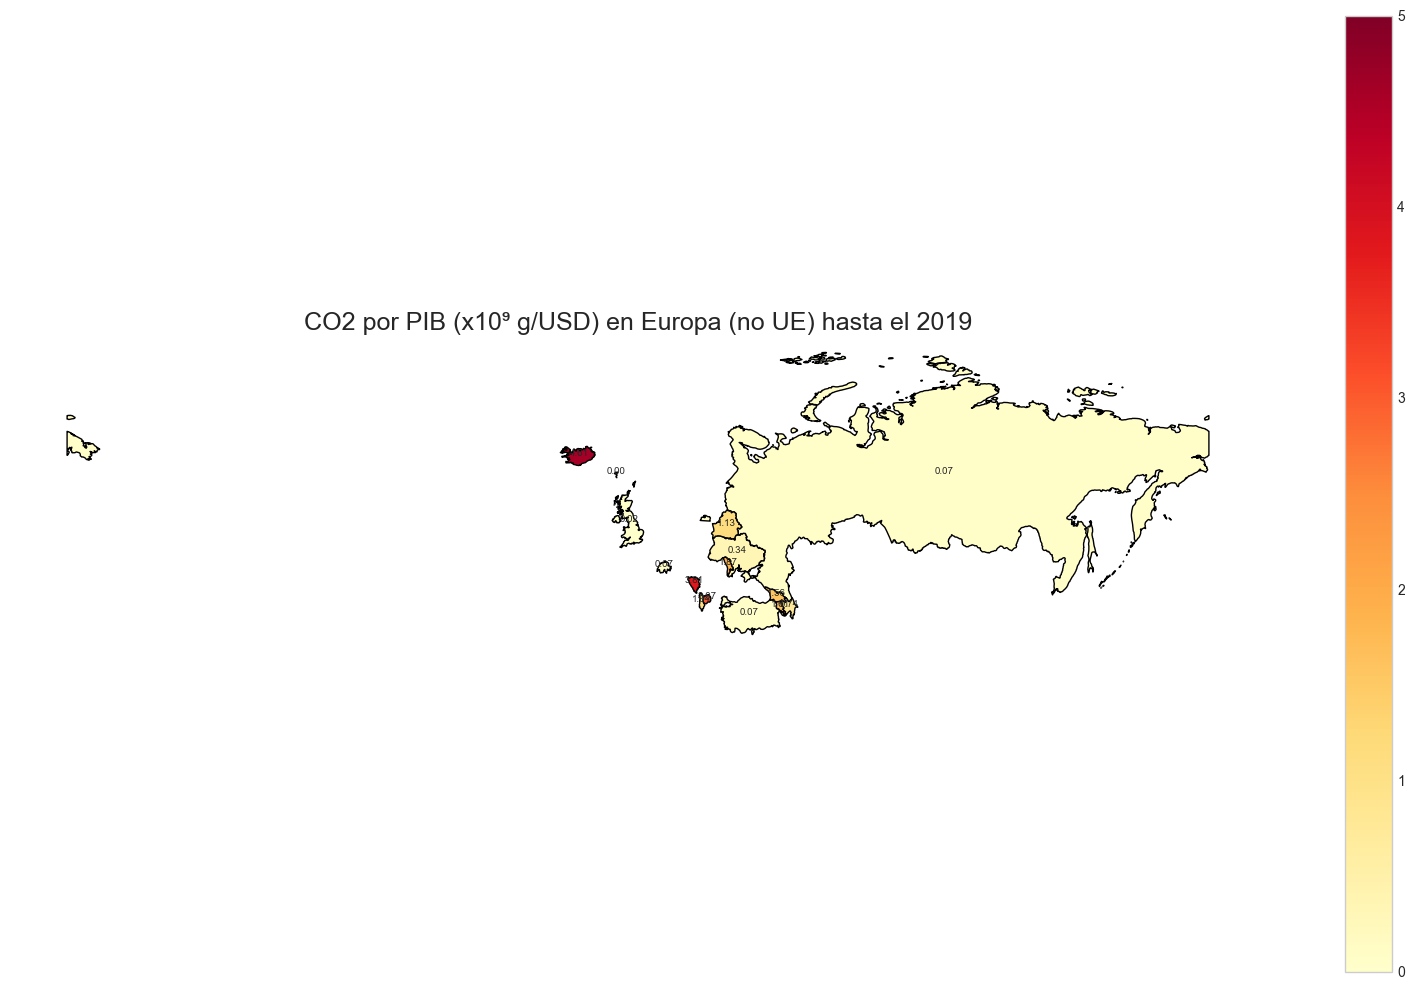

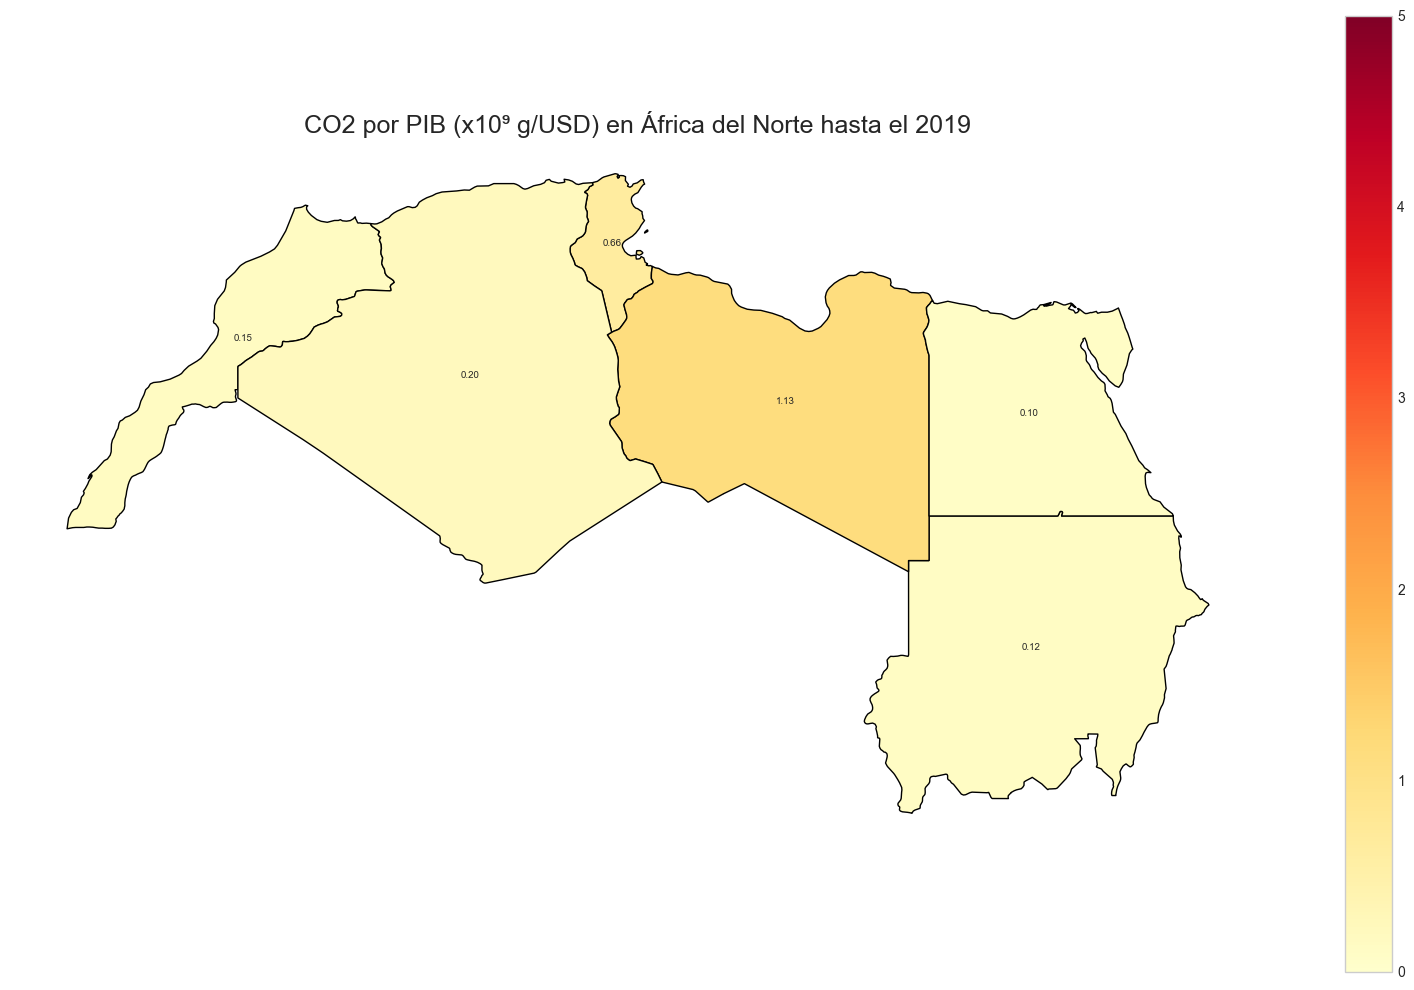

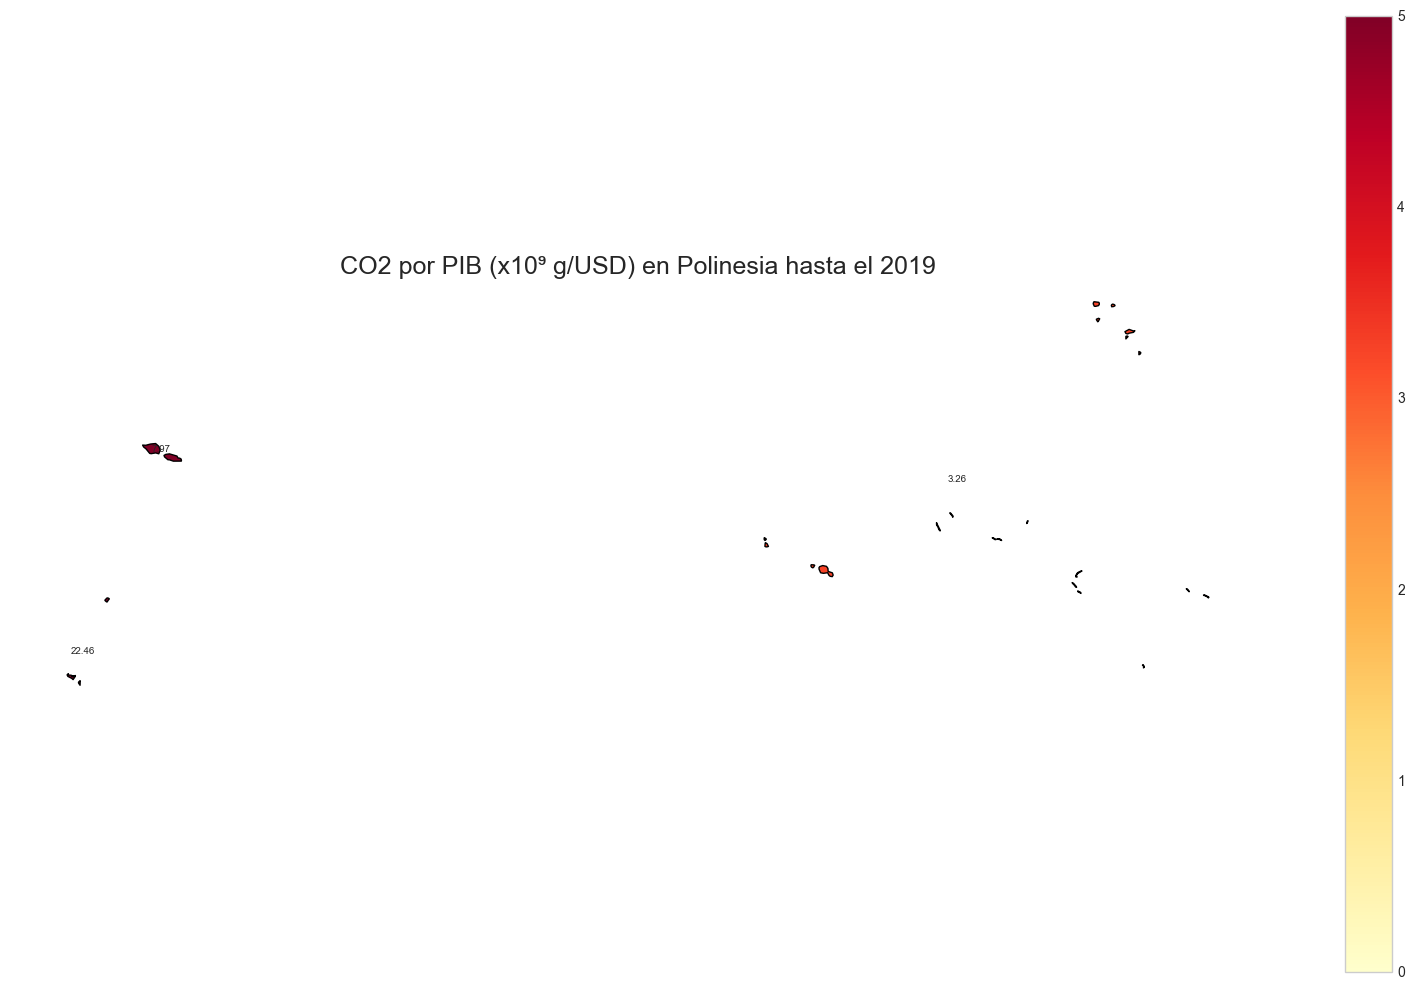

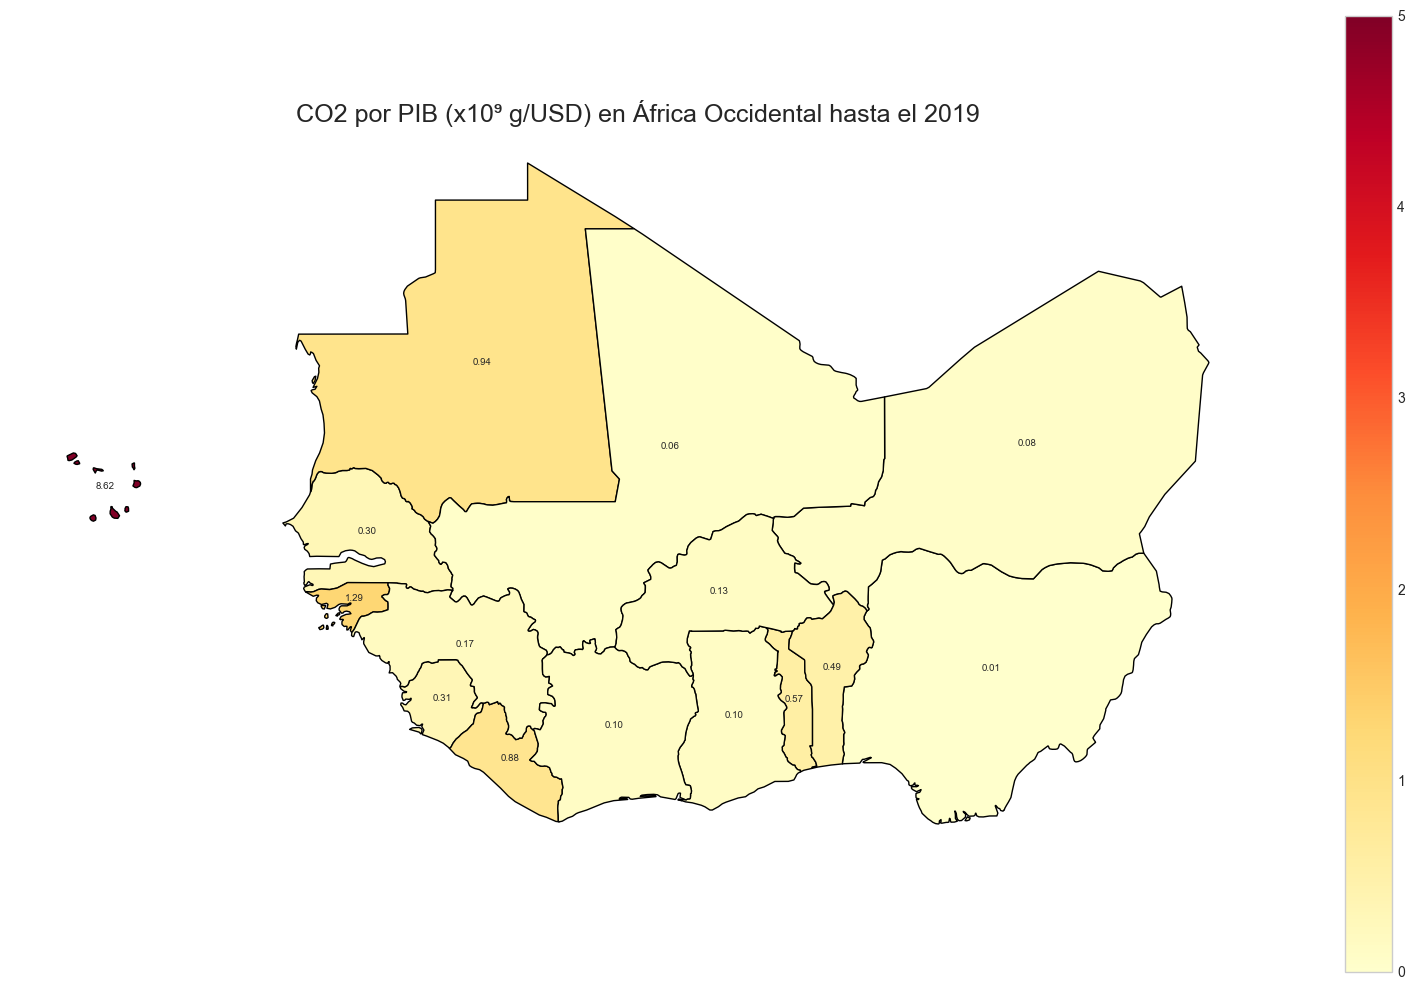

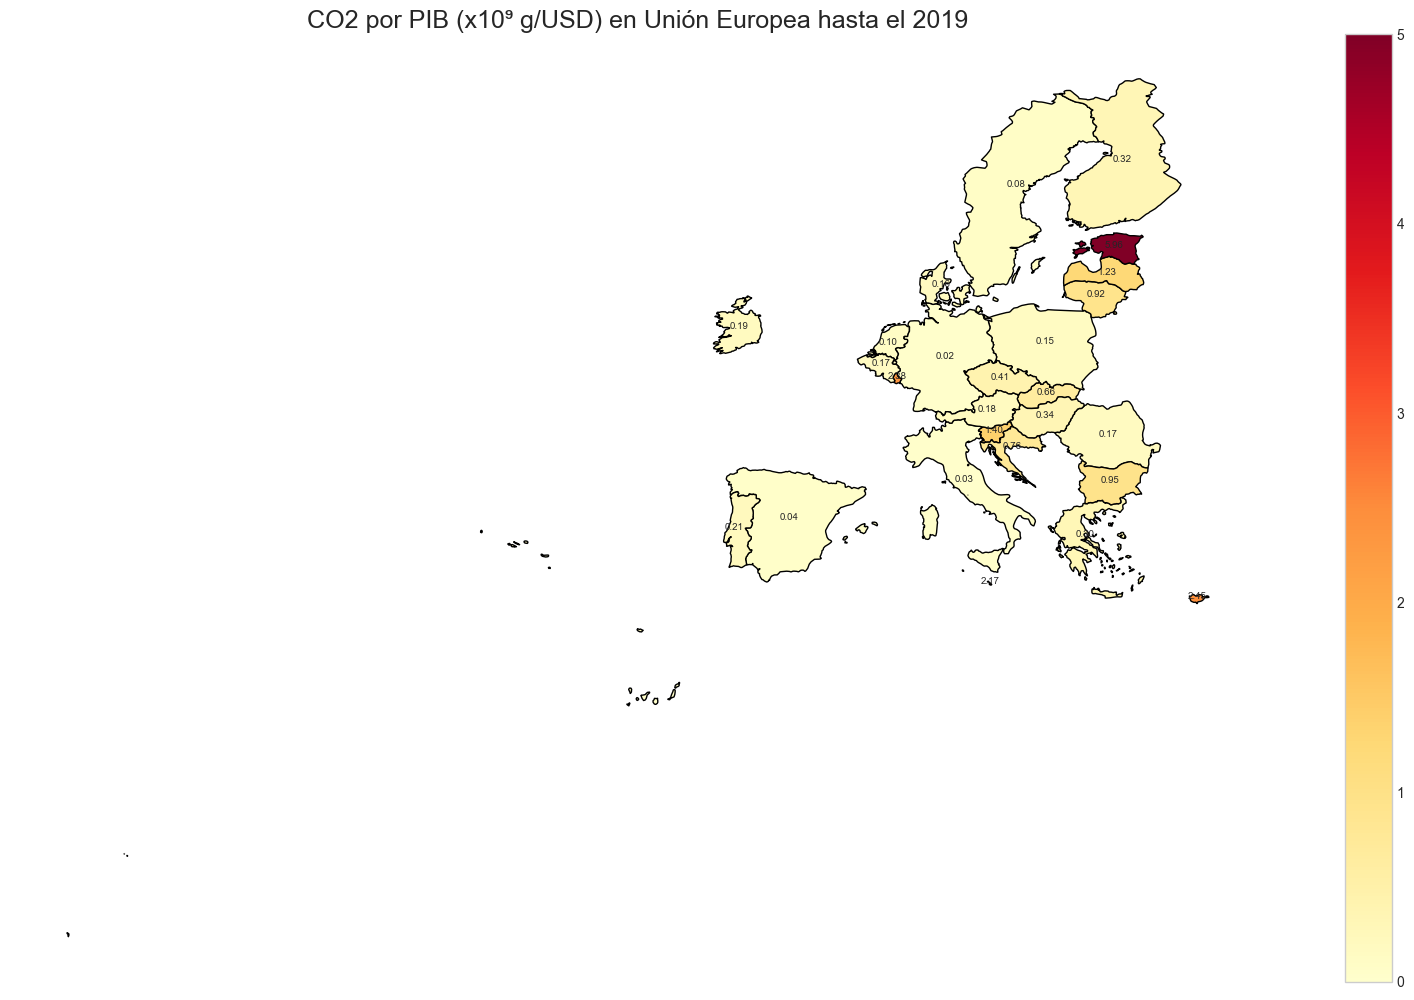

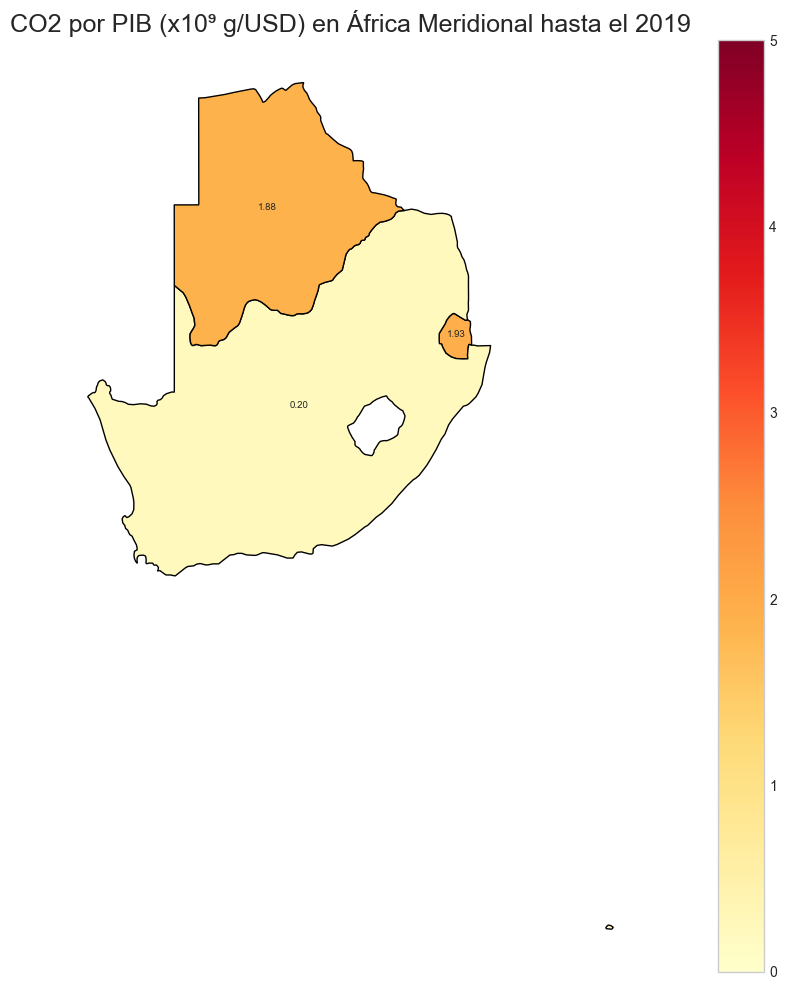

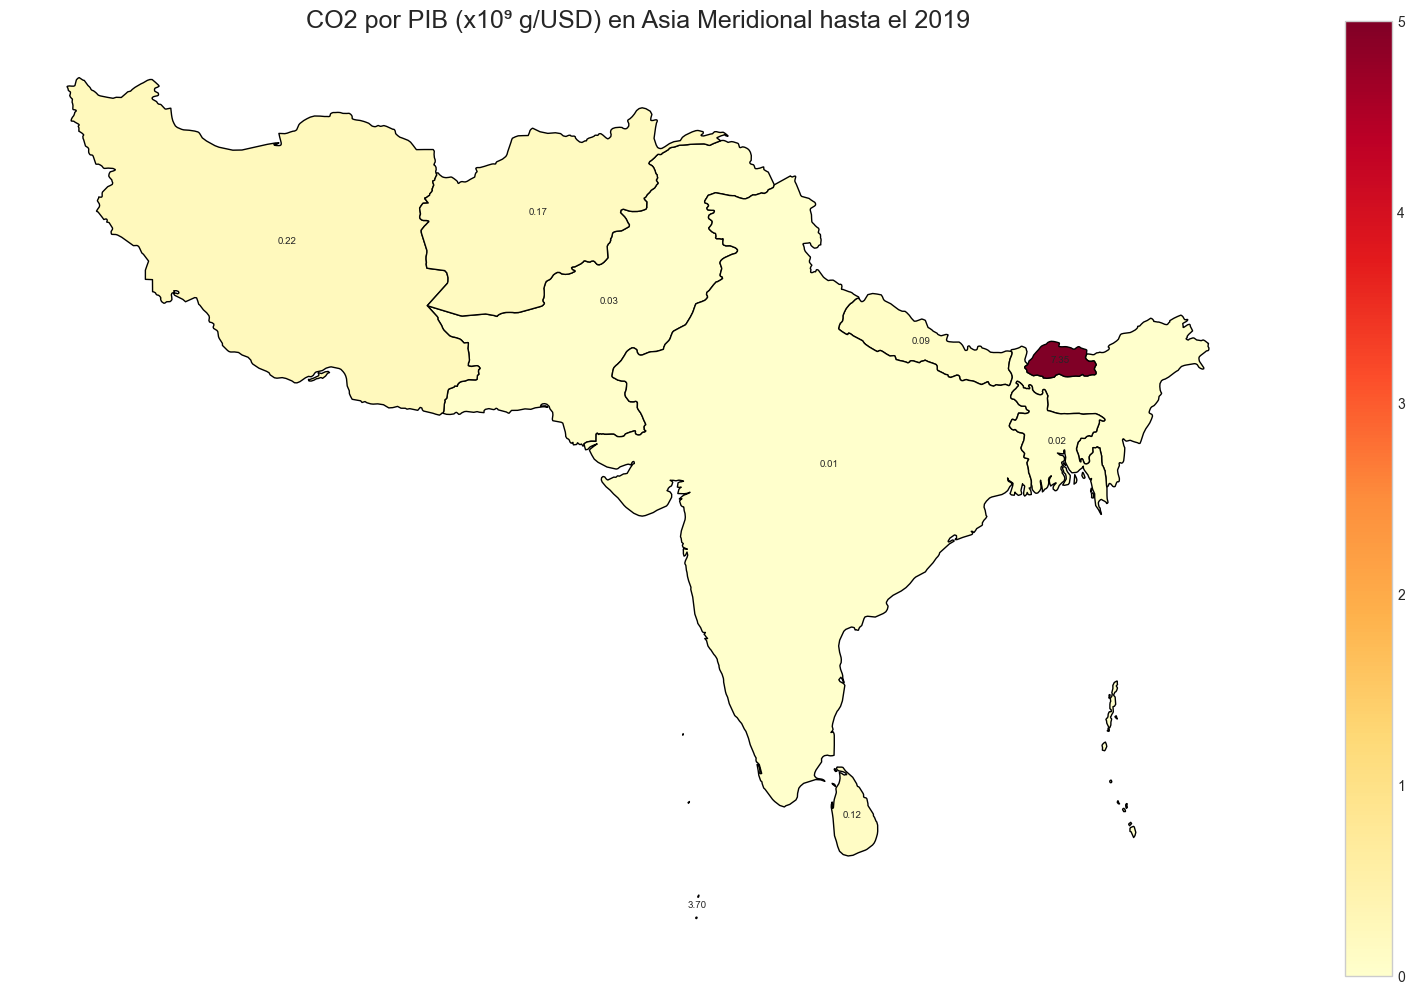

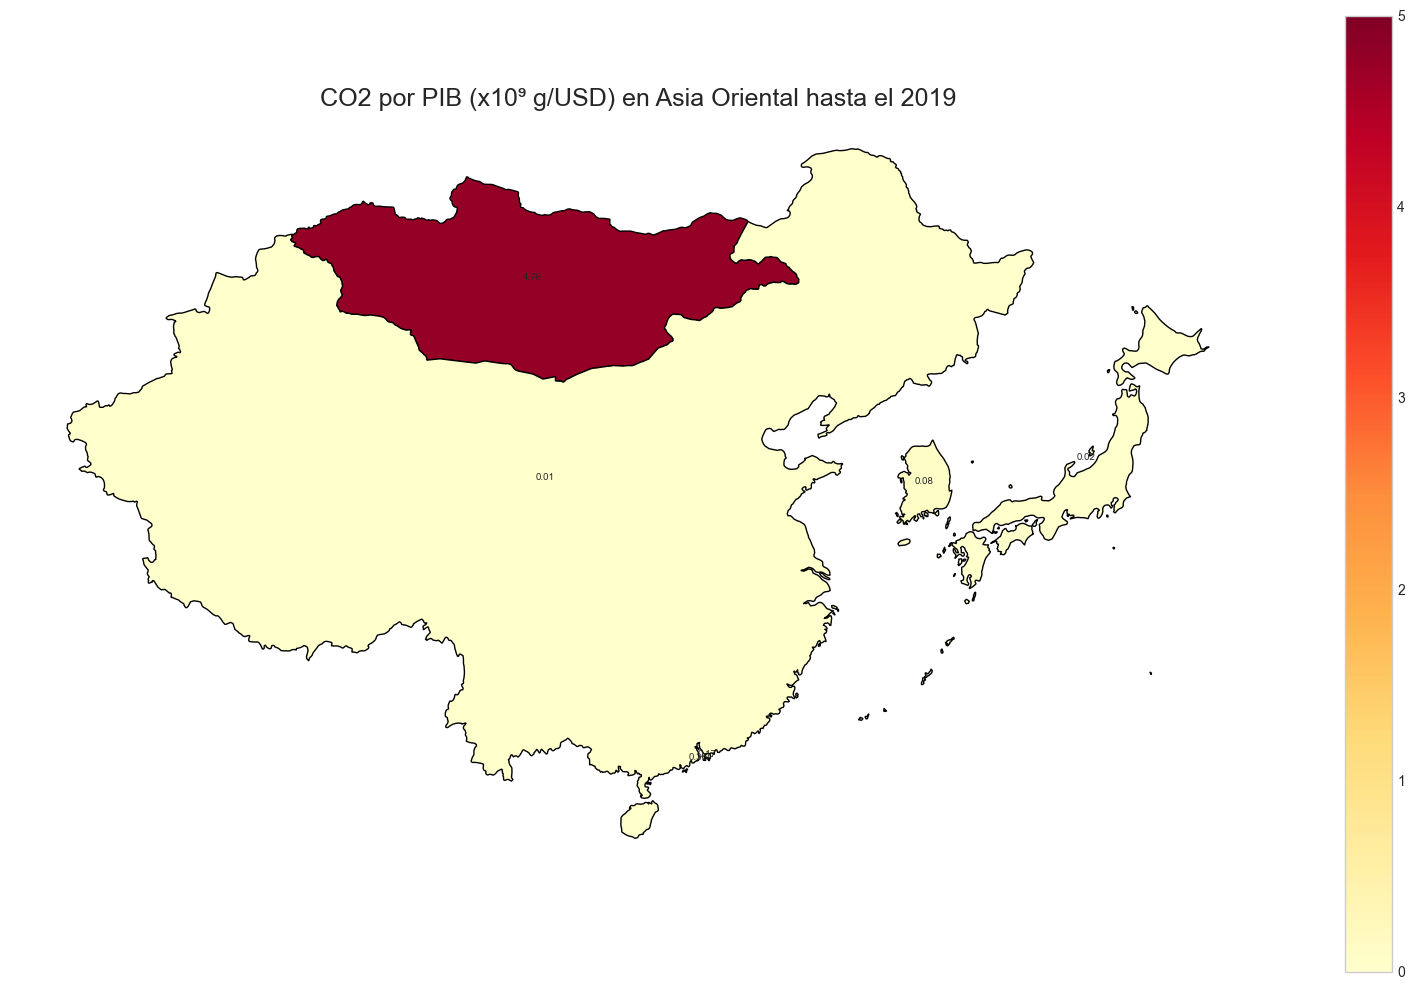

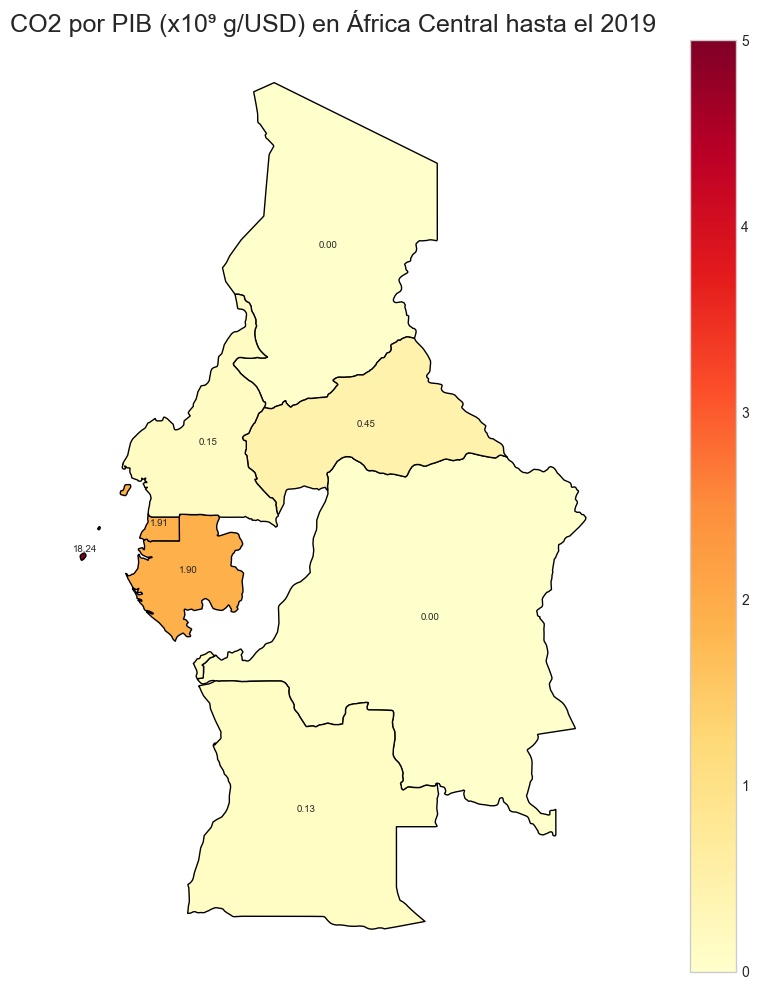

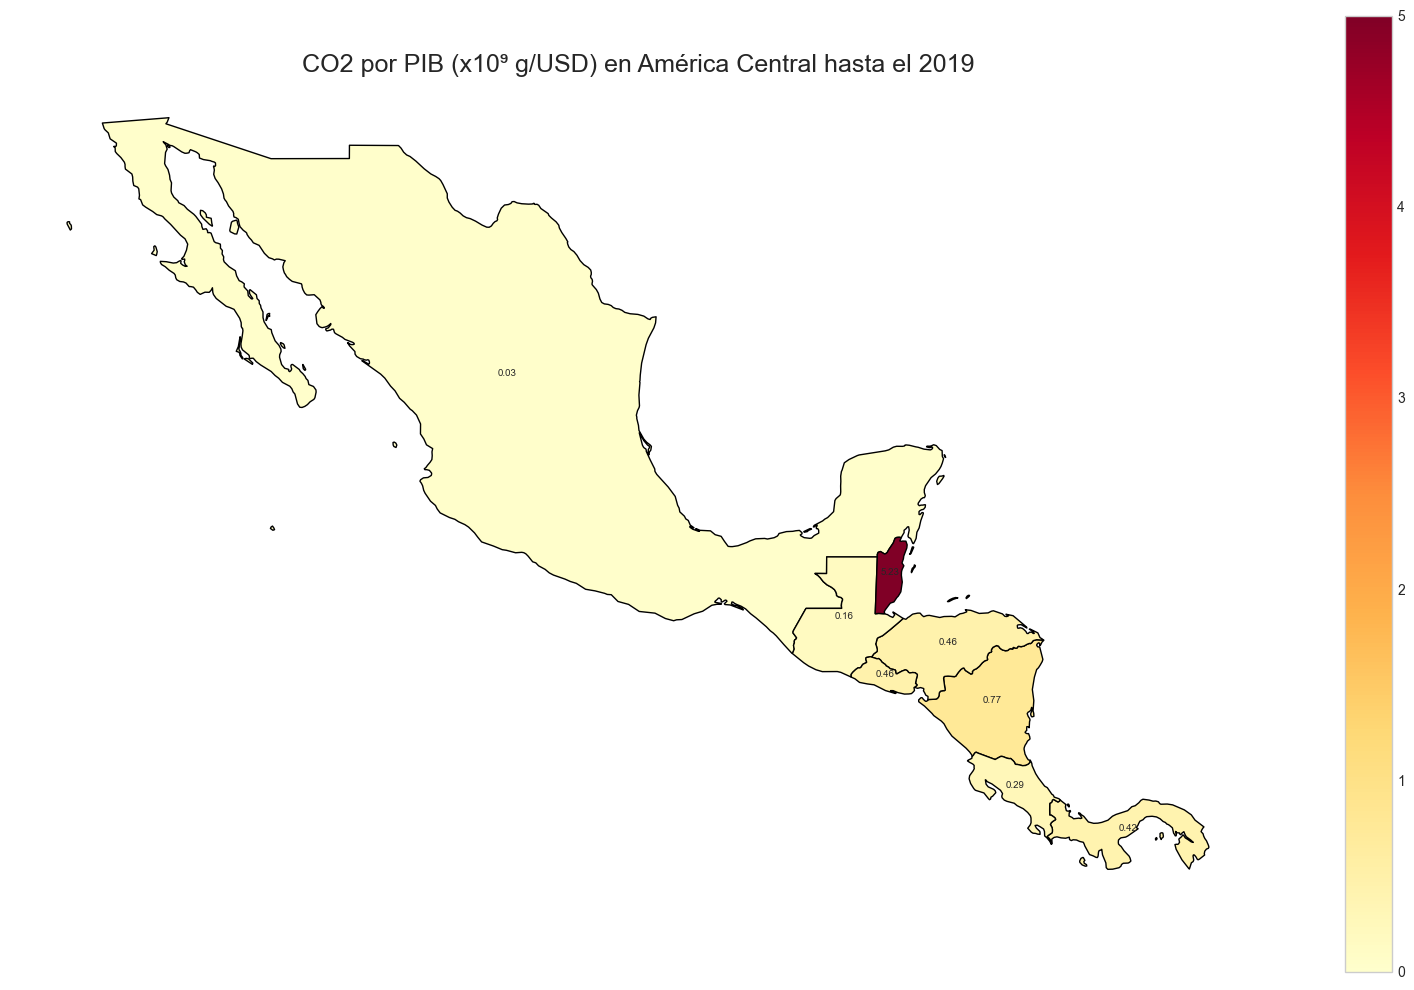

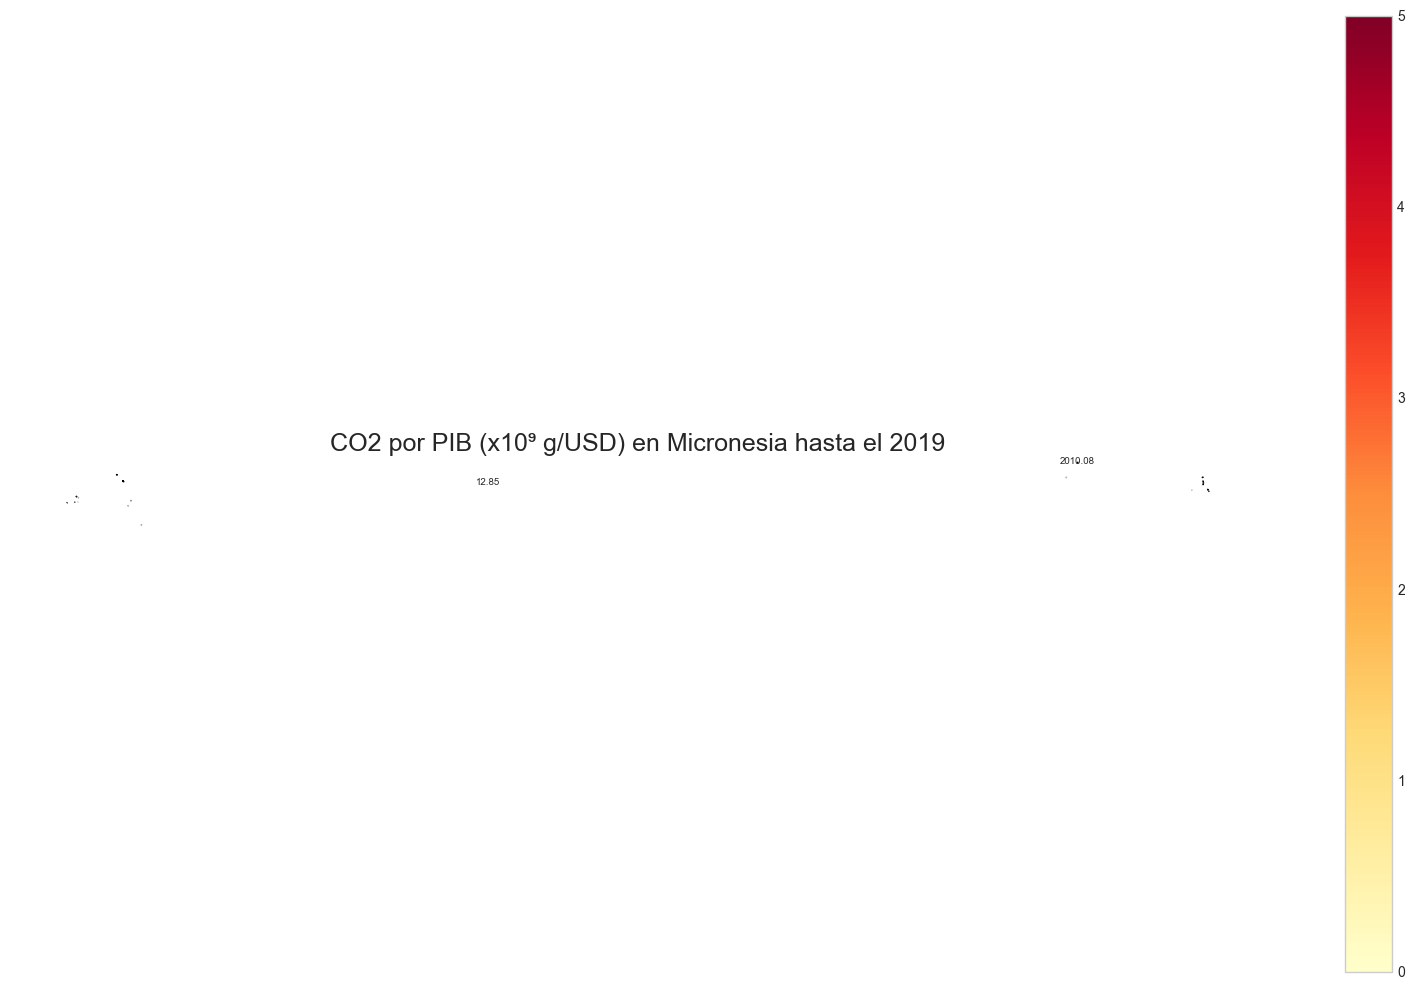

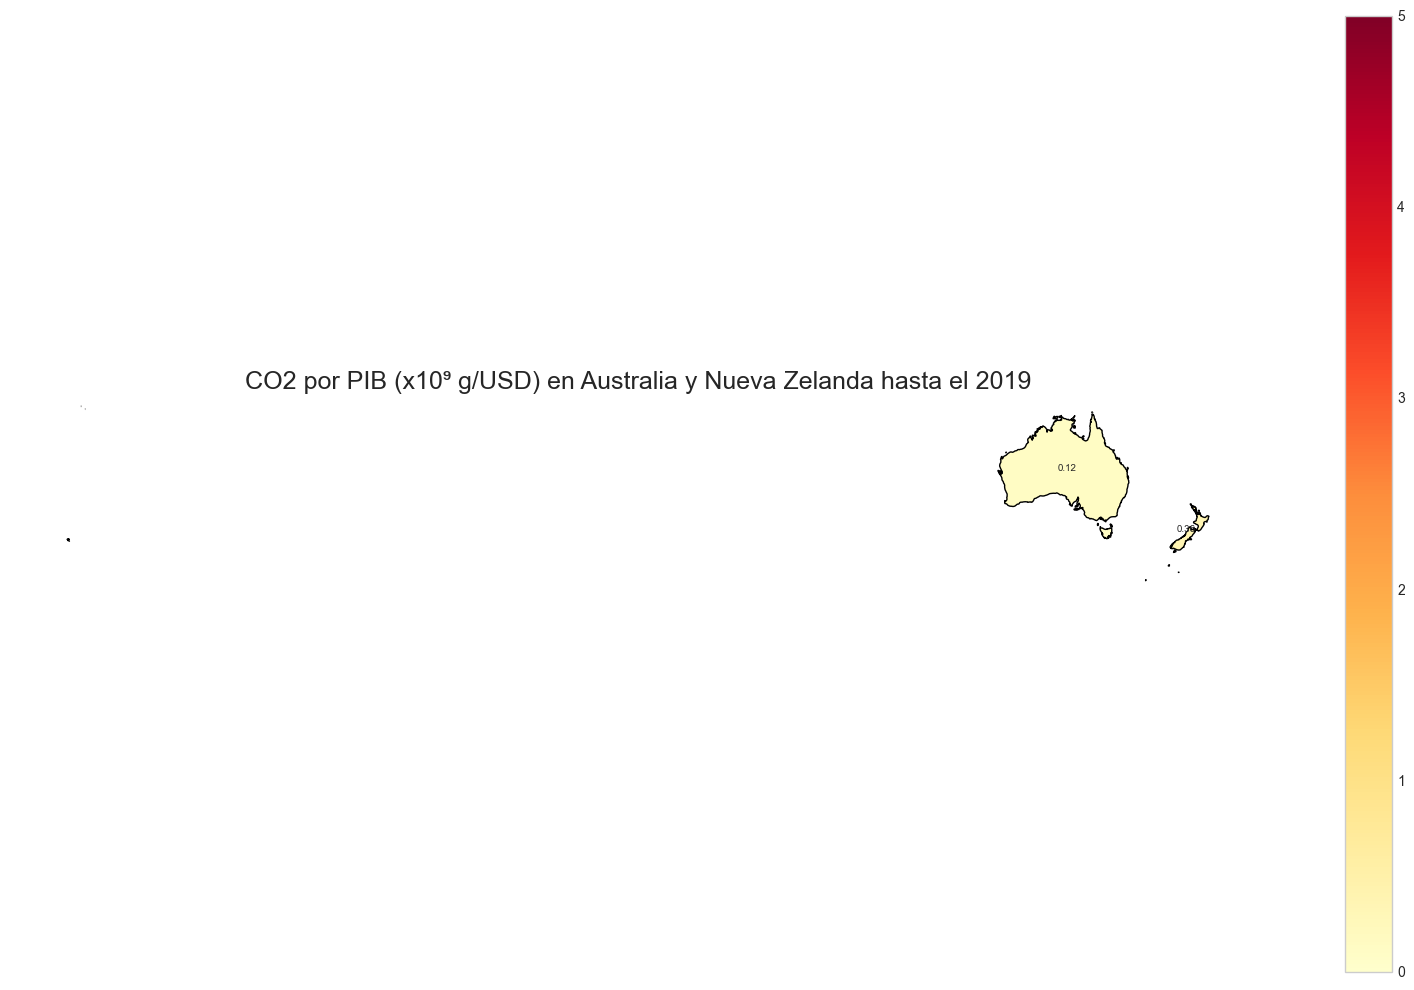

In [6]:
# ========================
# üìÑ Consulta SQL: PIB y CO2 de todos los pa√≠ses
# ========================
query = """
SELECT 
    h.anio,
    p.codigo AS pais_codigo,
    p.nombre AS pais_nombre,
    sc.nombre AS subcontinente,
    c.nombre AS continente,
    i.codigo AS indicador_codigo,
    h.valor
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes sc ON p.subcontinente_id = sc.id
JOIN continentes c ON sc.continente_id = c.id
WHERE (i.id = 2 OR i.codigo = 'NY.GDP.MKTP.CD')
  AND h.anio <= 2019
ORDER BY continente, subcontinente, pais_nombre, i.codigo;
"""

# ========================
# üì• Ejecutar y preparar datos
# ========================
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry

df = pd.read_sql(query, conn)

# ========================
# üîÅ Pivot: una fila por pa√≠s, a√±o
# ========================
df_pivot = df.pivot_table(
    index=["anio", "pais_codigo", "pais_nombre", "continente", "subcontinente"],
    columns="indicador_codigo",
    values="valor"
).reset_index()

# ========================
# üí° Renombrar columnas
# ========================
df_pivot.rename(columns={
    "NY.GDP.MKTP.CD": "PIB",
    "emision_co2": "CO2"
}, inplace=True)

# ========================
# üìÜ Filtrar a√±o m√°s reciente con datos v√°lidos
# ========================
df_pivot = df_pivot.dropna(subset=["PIB", "CO2"])
df_pivot = df_pivot[df_pivot["PIB"] > 0]
latest_year = df_pivot["anio"].max()
df_latest = df_pivot[df_pivot["anio"] == latest_year].copy()

# ========================
# ‚ûó Calcular CO‚ÇÇ por PIB y escalar
# ========================
df_latest["co2_por_pib"] = df_latest["CO2"] / df_latest["PIB"]
df_latest["co2_por_pib_scaled"] = df_latest["co2_por_pib"] * 1e10  # g/USD

# ========================
# üåç Convertir ISO2 ‚Üí ISO3
# ========================
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_latest["iso_a3"] = df_latest["pais_codigo"].apply(iso2_to_iso3)
df_latest = df_latest[df_latest["iso_a3"].notna()]

# ========================
# üì¶ Cargar shapefile y unir
# ========================
shapefile_path = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

map_data = world.merge(df_latest, how="inner", left_on="ISO_A3", right_on="iso_a3")
map_data = map_data[map_data["geometry"].notna()]

# ========================
# üéØ Escala com√∫n para todos los mapas
# ========================
vmin = 0.0
vmax = 5.0

# ========================
# üó∫Ô∏è Dibujar mapas por subcontinente
# ========================
subcontinentes = map_data["subcontinente"].unique()

for subcont in subcontinentes:
    subset = map_data[map_data["subcontinente"] == subcont]

    if subset.empty:
        continue

    ax = subset.plot(
        column="co2_por_pib_scaled",
        cmap="YlOrRd",
        legend=True,
        figsize=(16, 10),
        edgecolor="black",
        missing_kwds={"color": "lightgrey"},
        vmin=vmin,
        vmax=vmax
    )

    plt.title(f"CO2 por PIB (x10‚Åπ g/USD) en {subcont} hasta el 2019", fontsize=18)

    for idx, row in subset.iterrows():
        if row["geometry"].centroid.is_empty:
            continue
        x, y = row["geometry"].centroid.coords[0]
        plt.text(x, y, f"{row['co2_por_pib_scaled']:.2f}", fontsize=7, ha='center')

    plt.axis("off")
    plt.tight_layout()
    plt.show()


## 1. Resumen de Datos Disponibles

Primero, exploramos la cantidad de datos disponibles por pa√≠s y a√±o para tener una visi√≥n general de la cobertura de nuestro dataset.

In [7]:
# Consulta para obtener la cantidad de datos por pa√≠s y a√±o para emisiones de CO‚ÇÇ
query_resumen = """
SELECT 
    COUNT(DISTINCT p.codigo) AS num_paises,
    MIN(h.anio) AS anio_min,
    MAX(h.anio) AS anio_max,
    COUNT(DISTINCT h.anio) AS num_anios,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2';
"""

df_resumen = pd.read_sql(query_resumen, conn)

# Mostrar resumen
print("Resumen de datos de emisiones de CO‚ÇÇ:")
print(f"N√∫mero de pa√≠ses: {df_resumen['num_paises'].values[0]}")
print(f"Rango de a√±os: {df_resumen['anio_min'].values[0]} - {df_resumen['anio_max'].values[0]} ({df_resumen['num_anios'].values[0]} a√±os)")
print(f"Total de registros: {df_resumen['num_registros'].values[0]}")

# Consulta para obtener la cantidad de datos por pa√≠s y a√±o para PIB
query_resumen_pib = """
SELECT 
    COUNT(DISTINCT p.codigo) AS num_paises,
    MIN(h.anio) AS anio_min,
    MAX(h.anio) AS anio_max,
    COUNT(DISTINCT h.anio) AS num_anios,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'NY.GDP.MKTP.CD';
"""

df_resumen_pib = pd.read_sql(query_resumen_pib, conn)

# Mostrar resumen
print("\nResumen de datos de PIB:")
print(f"N√∫mero de pa√≠ses: {df_resumen_pib['num_paises'].values[0]}")
print(f"Rango de a√±os: {df_resumen_pib['anio_min'].values[0]} - {df_resumen_pib['anio_max'].values[0]} ({df_resumen_pib['num_anios'].values[0]} a√±os)")
print(f"Total de registros: {df_resumen_pib['num_registros'].values[0]}")

Resumen de datos de emisiones de CO‚ÇÇ:
N√∫mero de pa√≠ses: 198
Rango de a√±os: 1990 - 2021 (28 a√±os)
Total de registros: 5422

Resumen de datos de PIB:
N√∫mero de pa√≠ses: 209
Rango de a√±os: 1960 - 2023 (64 a√±os)
Total de registros: 11187


C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\1188947418.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen = pd.read_sql(query_resumen, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\1188947418.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen_pib = pd.read_sql(query_resumen_pib, conn)


## 2. Tendencia Global de Emisiones de CO‚ÇÇ

Analizamos la evoluci√≥n de las emisiones globales de CO‚ÇÇ a lo largo del tiempo.

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\94643270.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


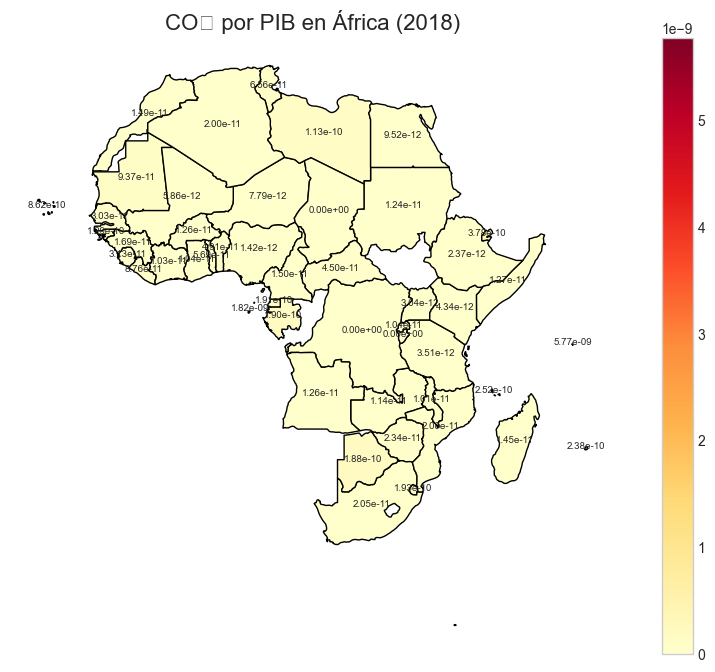

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


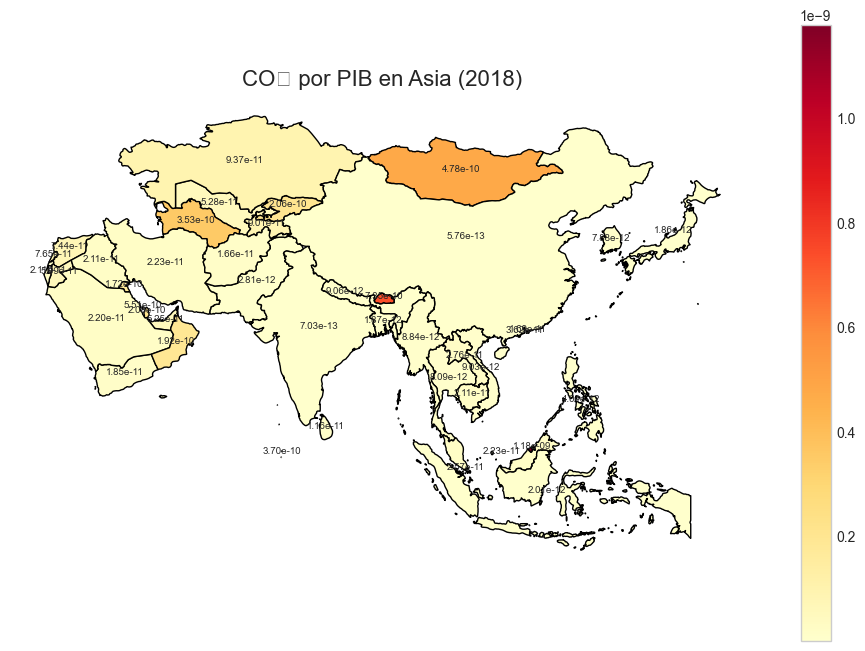

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


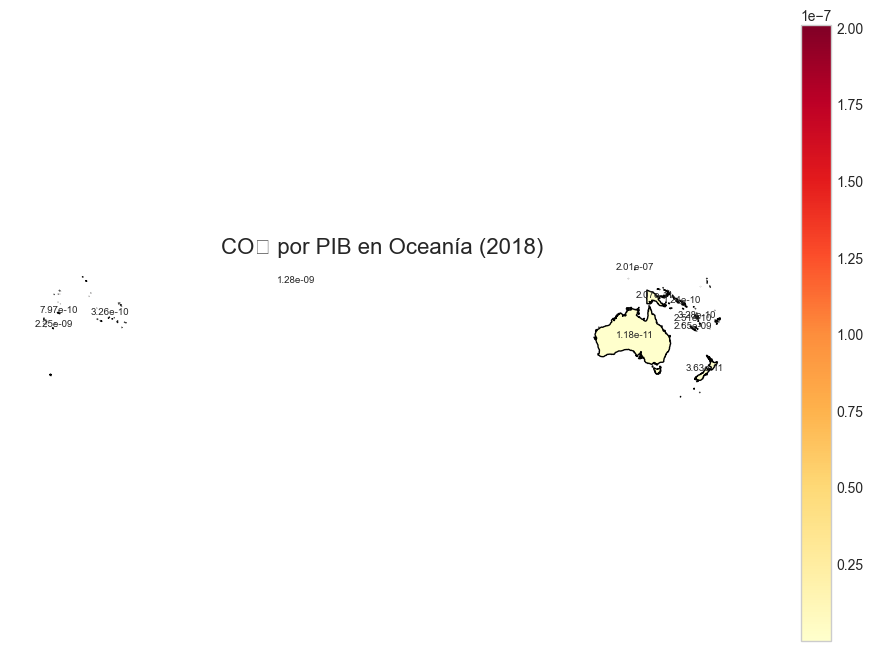

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


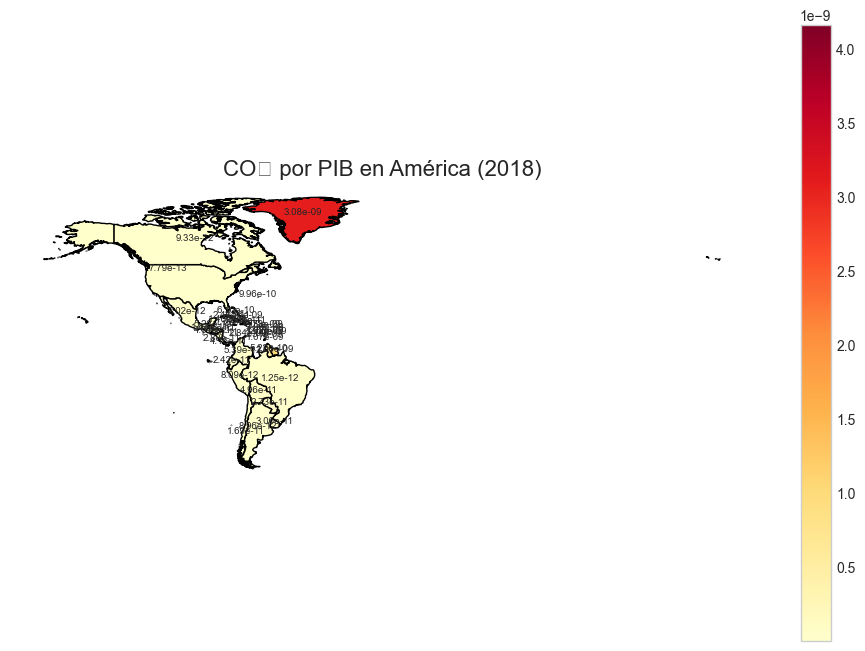

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


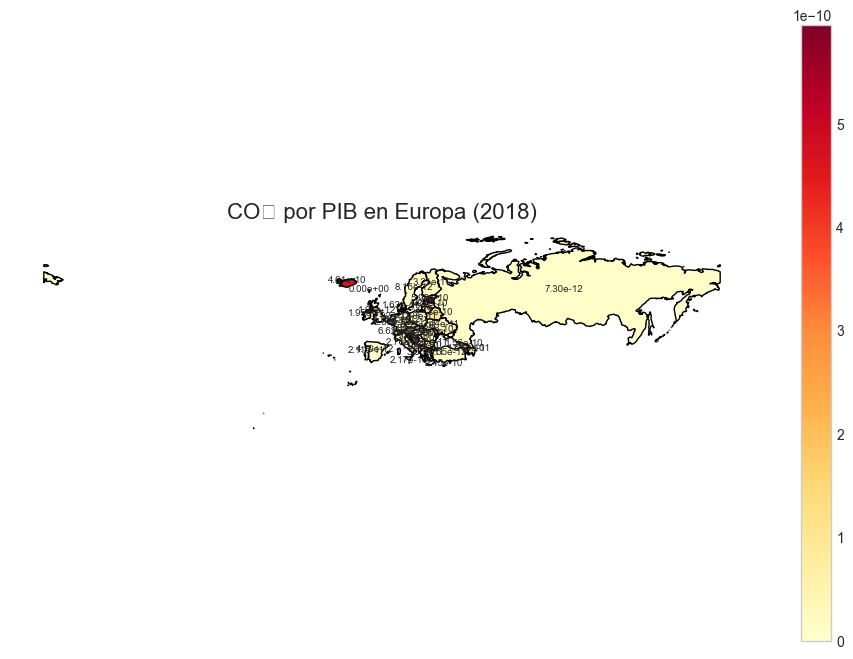

In [8]:
# ========================
# üìÑ Consulta SQL: PIB y CO2 de todos los pa√≠ses
# ========================
query = """
SELECT 
    h.anio,
    p.codigo AS pais_codigo,
    p.nombre AS pais_nombre,
    sc.nombre AS subcontinente,
    c.nombre AS continente,
    i.codigo AS indicador_codigo,
    h.valor
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes sc ON p.subcontinente_id = sc.id
JOIN continentes c ON sc.continente_id = c.id
WHERE (i.id = 2 OR i.codigo = 'NY.GDP.MKTP.CD')
  AND h.anio <= 2019
ORDER BY continente, subcontinente, pais_nombre, i.codigo;
"""

# ========================
# üì• Ejecutar y preparar datos
# ========================
df = pd.read_sql(query, conn)

# ========================
# üîÅ Pivot: una fila por pa√≠s, a√±o
# ========================
df_pivot = df.pivot_table(
    index=["anio", "pais_codigo", "pais_nombre", "continente", "subcontinente"],
    columns="indicador_codigo",
    values="valor"
).reset_index()

# ========================
# üí° Normalizar nombres de columnas
# ========================
df_pivot.rename(columns={
    "NY.GDP.MKTP.CD": "PIB",
    "emision_co2": "CO2"
}, inplace=True)

# ========================
# üìÜ Filtrar √∫ltimo a√±o con datos v√°lidos
# ========================
df_pivot = df_pivot.dropna(subset=["PIB", "CO2"])
df_pivot = df_pivot[df_pivot["PIB"] > 0]
latest_year = df_pivot["anio"].max()
df_latest = df_pivot[df_pivot["anio"] == latest_year].copy()

# ========================
# ‚ûó Calcular CO2 por PIB
# ========================
df_latest["co2_por_pib"] = df_latest["CO2"] / df_latest["PIB"]

# ========================
# üåç Convertir ISO2 ‚Üí ISO3
# ========================
import pycountry
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_latest["iso_a3"] = df_latest["pais_codigo"].apply(iso2_to_iso3)
df_latest = df_latest[df_latest["iso_a3"].notna()]

# ========================
# üó∫Ô∏è Cargar shapefile y merge
# ========================
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
map_data = world.merge(df_latest, how="inner", left_on="ISO_A3", right_on="iso_a3")
map_data = map_data[map_data["geometry"].notna()]

# ========================
# üìä Graficar mapas por continente
# ========================
continentes = map_data["continente"].unique()

for cont in continentes:
    subset = map_data[map_data["continente"] == cont]

    if subset.empty:
        continue

    ax = subset.plot(
        column="co2_por_pib",
        cmap="YlOrRd",
        legend=True,
        figsize=(12, 8),
        edgecolor="black",
        missing_kwds={"color": "lightgrey"}
    )
    plt.title(f"CO‚ÇÇ por PIB en {cont} ({latest_year})", fontsize=16)

    # Anotar cada pa√≠s
    for idx, row in subset.iterrows():
        if row["geometry"].centroid.is_empty:
            continue
        x, y = row["geometry"].centroid.coords[0]
        plt.text(x, y, f"{row['co2_por_pib']:.2e}", fontsize=7, ha='center')

    plt.axis("off")
    plt.show()


## 3. Emisiones de CO‚ÇÇ por Continente

Analizamos la contribuci√≥n de cada continente a las emisiones globales y su evoluci√≥n.

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\2365128906.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_continentes = pd.read_sql(query_continentes, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\2365128906.py:36: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


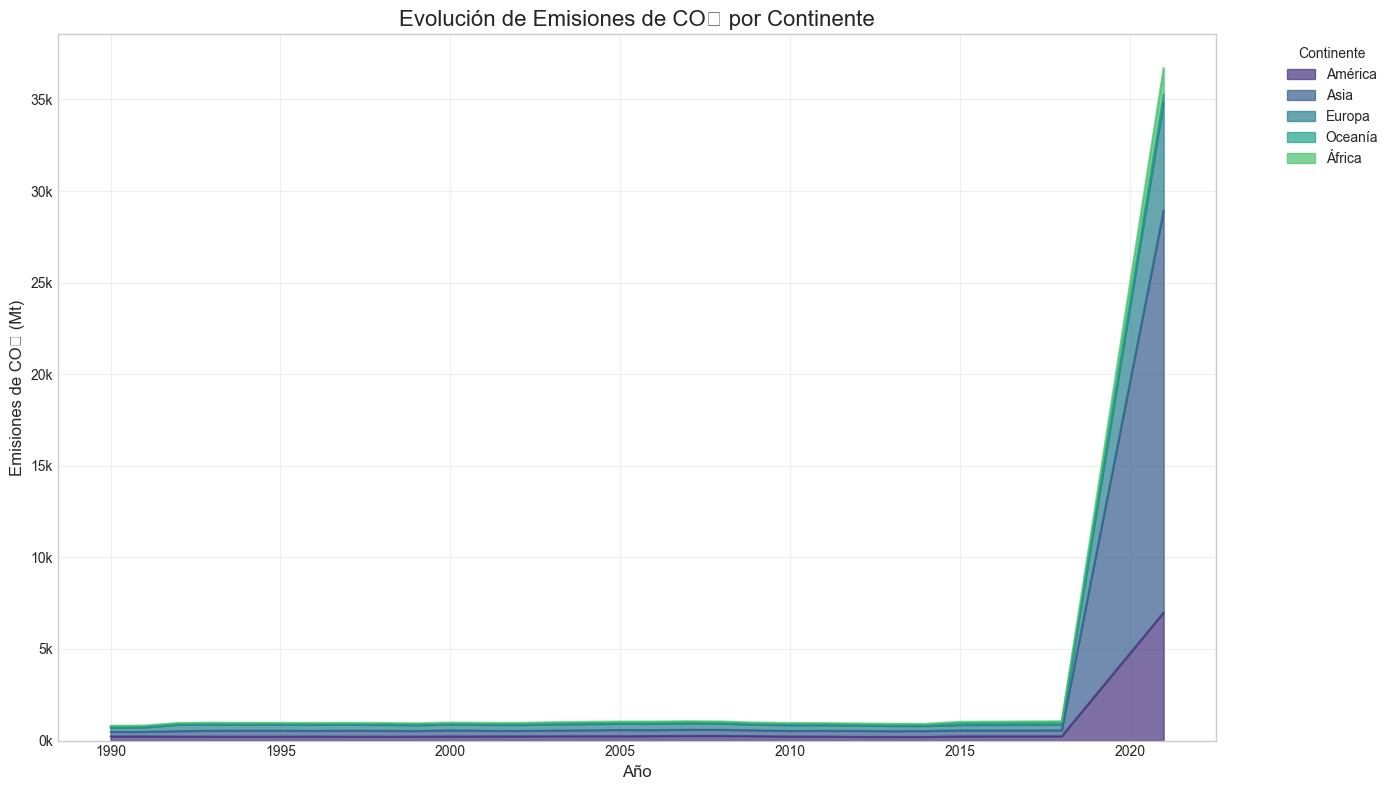

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\2365128906.py:51: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


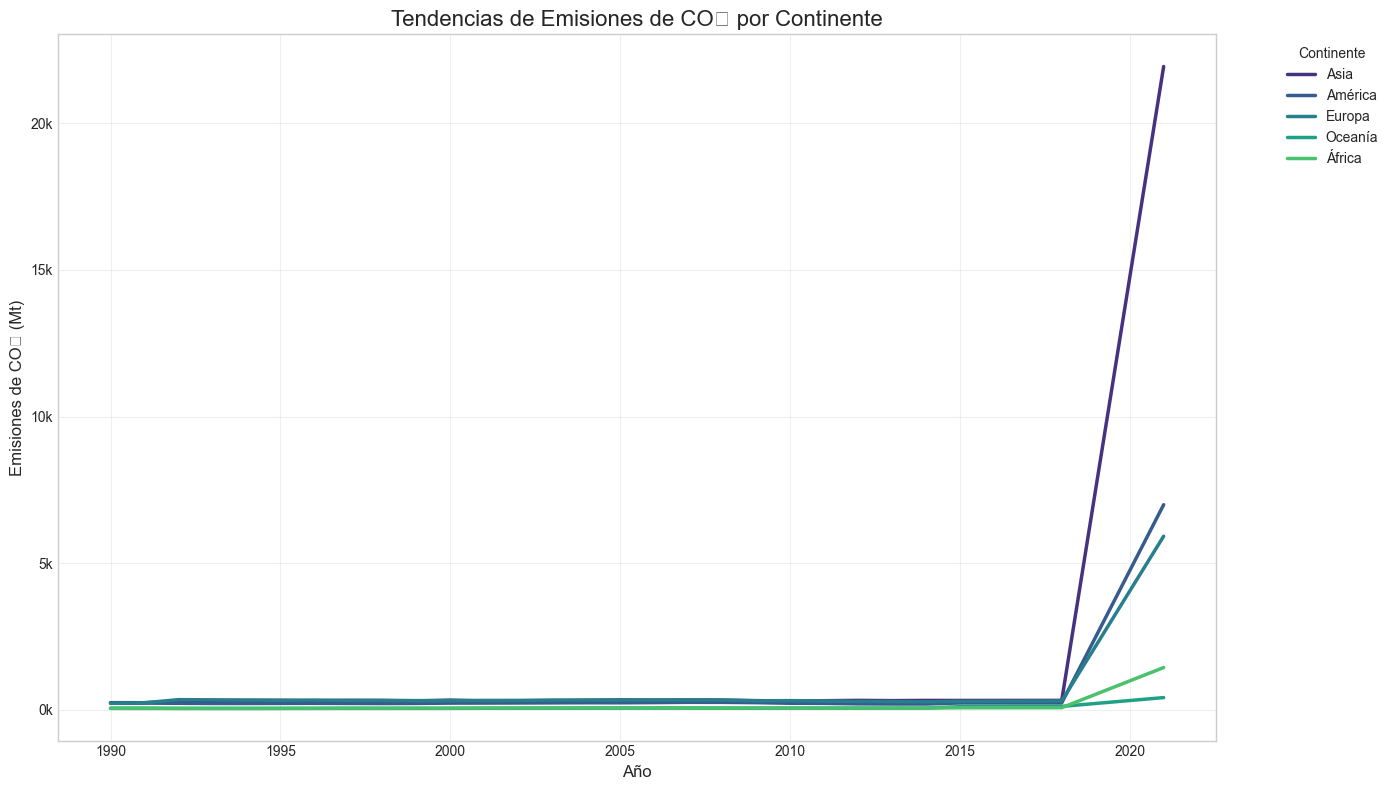

In [9]:
# Consulta para obtener emisiones por continente y a√±o
query_continentes = """
SELECT 
    h.anio,
    c.nombre AS continente,
    SUM(h.valor) AS emisiones
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Subcontinentes s ON p.subcontinente_id = s.id
JOIN Continentes c ON s.continente_id = c.id
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
GROUP BY h.anio, c.nombre
ORDER BY h.anio, emisiones DESC;
"""

df_continentes = pd.read_sql(query_continentes, conn)

# Crear gr√°fico de √°rea apilada para emisiones por continente
plt.figure(figsize=(14, 8))

# Pivotear datos para el gr√°fico de √°rea
df_pivot = df_continentes.pivot(index='anio', columns='continente', values='emisiones').fillna(0)

# Crear gr√°fico de √°rea apilada
df_pivot.plot.area(stacked=True, alpha=0.7, figsize=(14, 8))

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('A√±o', fontsize=12)
plt.ylabel('Emisiones de CO‚ÇÇ (Mt)', fontsize=12)
plt.title('Evoluci√≥n de Emisiones de CO‚ÇÇ por Continente', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Crear gr√°fico de l√≠neas para comparar tendencias por continente
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_continentes, x='anio', y='emisiones', hue='continente', linewidth=2.5)

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('A√±o', fontsize=12)
plt.ylabel('Emisiones de CO‚ÇÇ (Mt)', fontsize=12)
plt.title('Tendencias de Emisiones de CO‚ÇÇ por Continente', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Top 15 Pa√≠ses Emisores

Identificamos los principales pa√≠ses emisores de CO‚ÇÇ y analizamos su evoluci√≥n.

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\40364669.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_paises = pd.read_sql(query_top_paises, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\40364669.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_paises, y='pais', x='emisiones', palette='viridis')
C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\40364669.py:33: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canv

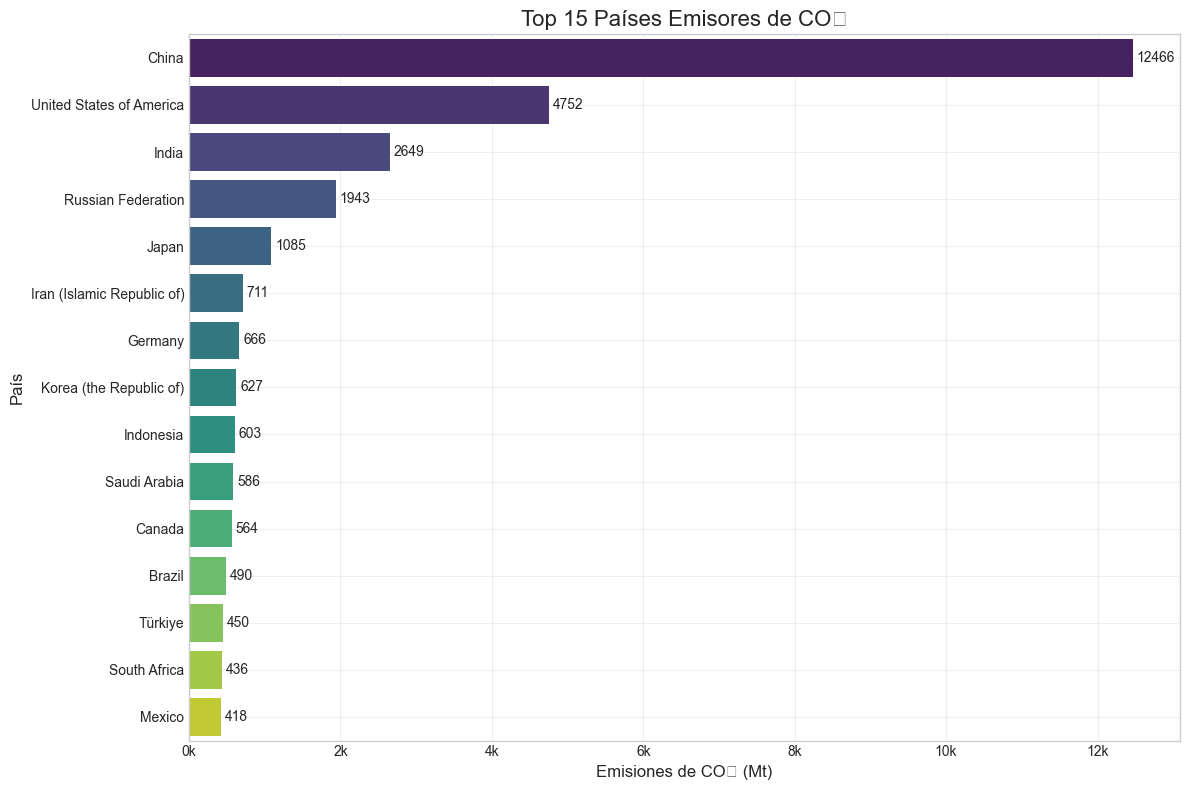

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\40364669.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_evolucion_top = pd.read_sql(query_evolucion_top, conn, params=top5_paises)
C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\40364669.py:67: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


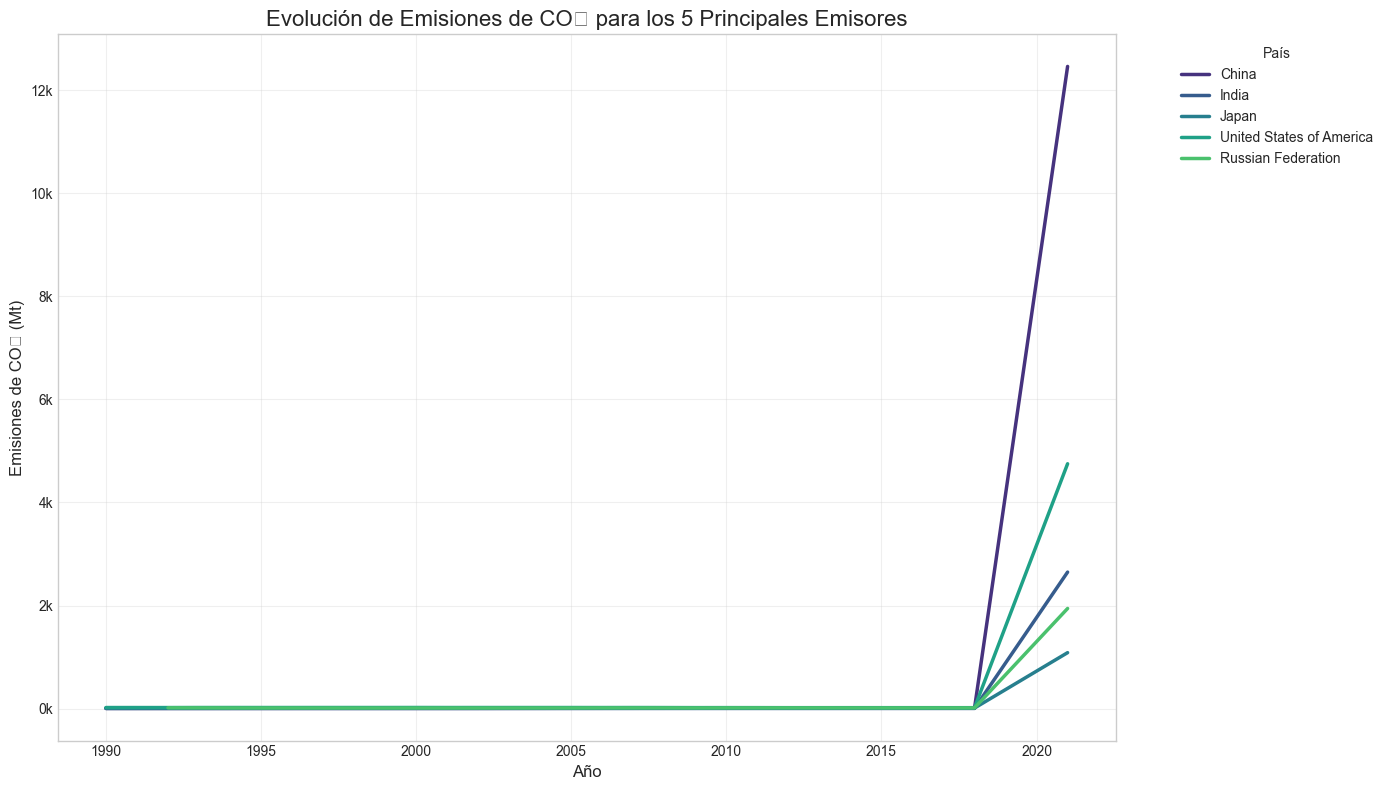

In [10]:
# Consulta para obtener los 15 principales pa√≠ses emisores en el a√±o m√°s reciente
query_top_paises = """
SELECT 
    p.nombre_en AS pais,
    p.codigo AS codigo_pais,
    h.valor AS emisiones
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
AND h.anio = (SELECT MAX(anio) FROM Hechos WHERE indicador_id = i.id)
ORDER BY emisiones DESC
LIMIT 15;
"""

df_top_paises = pd.read_sql(query_top_paises, conn)

# Crear gr√°fico de barras horizontales para los principales emisores
plt.figure(figsize=(12, 8))
sns.barplot(data=df_top_paises, y='pais', x='emisiones', palette='viridis')

# Formatear eje x en millones
plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_millones))

# A√±adir etiquetas con valores
for i, v in enumerate(df_top_paises['emisiones']):
    plt.text(v + 50, i, f'{v:.0f}', va='center')

plt.xlabel('Emisiones de CO‚ÇÇ (Mt)', fontsize=12)
plt.ylabel('Pa√≠s', fontsize=12)
plt.title('Top 15 Pa√≠ses Emisores de CO‚ÇÇ', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Consulta para obtener la evoluci√≥n de los 5 principales emisores
top5_paises = df_top_paises['codigo_pais'].head(5).tolist()

placeholders = ', '.join(['%s'] * len(top5_paises))
query_evolucion_top = f"""
SELECT 
    h.anio,
    p.nombre_en AS pais,
    h.valor AS emisiones
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
AND p.codigo IN ({placeholders})
ORDER BY h.anio;
"""

df_evolucion_top = pd.read_sql(query_evolucion_top, conn, params=top5_paises)

# Crear gr√°fico de l√≠neas para la evoluci√≥n de los principales emisores
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_evolucion_top, x='anio', y='emisiones', hue='pais', linewidth=2.5)

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('A√±o', fontsize=12)
plt.ylabel('Emisiones de CO‚ÇÇ (Mt)', fontsize=12)
plt.title('Evoluci√≥n de Emisiones de CO‚ÇÇ para los 5 Principales Emisores', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Pa√≠s', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Relaci√≥n entre PIB y Emisiones de CO‚ÇÇ

Analizamos la correlaci√≥n entre el desarrollo econ√≥mico (PIB) y las emisiones de CO‚ÇÇ.

C:\Users\jcall\AppData\Local\Temp\ipykernel_12296\2410820855.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pib_co2 = pd.read_sql(query_pib_co2, conn)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


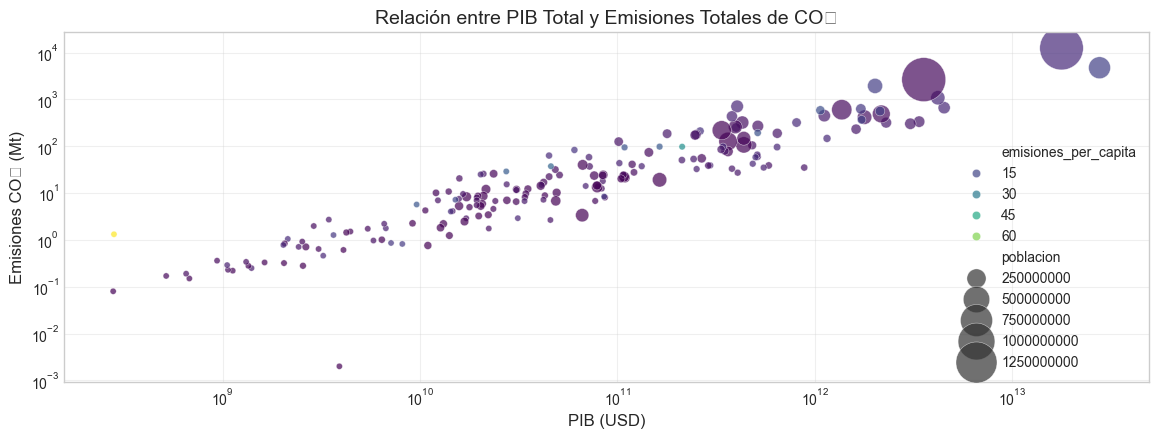

In [11]:
# Consulta para obtener PIB y emisiones de CO‚ÇÇ para el a√±o m√°s reciente
query_pib_co2 = """
WITH ranked AS (
  SELECT
    h.pais_id,
    p.nombre_en AS pais,
    i.codigo AS indicador,
    h.valor,
    ROW_NUMBER() OVER (
      PARTITION BY h.pais_id, h.indicador_id
      ORDER BY h.anio DESC
    ) AS rn
  FROM Hechos h
  JOIN Paises p    ON h.pais_id      = p.codigo
  JOIN Indicadores i ON h.indicador_id = i.id
  WHERE i.codigo IN (
    'NY.GDP.MKTP.CD', 
    'emision_co2', 
    'SP.POP.TOTL'
  )
)
SELECT
  pais,
  pais_id AS codigo_pais,
  MAX(CASE WHEN indicador = 'NY.GDP.MKTP.CD' THEN valor END)    AS pib,
  MAX(CASE WHEN indicador = 'emision_co2' THEN valor END)      AS emisiones_co2,
  MAX(CASE WHEN indicador = 'SP.POP.TOTL' THEN valor END)      AS poblacion
FROM ranked
WHERE rn = 1
GROUP BY pais, codigo_pais
HAVING pib IS NOT NULL
   AND emisiones_co2 IS NOT NULL
   AND poblacion IS NOT NULL
ORDER BY pib DESC;
"""

df_pib_co2 = pd.read_sql(query_pib_co2, conn)

# Calcular emisiones per c√°pita y PIB per c√°pita
df_pib_co2['emisiones_per_capita'] = df_pib_co2['emisiones_co2'] * 1000000 / df_pib_co2['poblacion']
df_pib_co2['pib_per_capita'] = df_pib_co2['pib'] / df_pib_co2['poblacion']

# Crear gr√°fico de dispersi√≥n para PIB vs Emisiones
plt.figure(figsize=(14, 10))

# Gr√°fico 1: PIB total vs Emisiones totales
plt.subplot(2, 1, 1)
sns.scatterplot(
    data=df_pib_co2,
    x='pib',
    y='emisiones_co2',
    size='poblacion',
    sizes=(20, 1000),
    alpha=0.7,
    hue='emisiones_per_capita',
    palette='viridis'
)

# A√±adir etiquetas para pa√≠ses destacados
paises_destacados = ['USA', 'CHN', 'IND', 'DEU', 'JPN', 'RUS', 'BRA', 'GBR', 'FRA', 'ESP']
for idx, row in df_pib_co2[df_pib_co2['codigo_pais'].isin(paises_destacados)].iterrows():
    plt.annotate(row['codigo_pais'], 
                xy=(row['pib'], row['emisiones_co2']), 
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('PIB (USD)', fontsize=12)
plt.ylabel('Emisiones CO‚ÇÇ (Mt)', fontsize=12)
plt.title('Relaci√≥n entre PIB Total y Emisiones Totales de CO‚ÇÇ', fontsize=14)
plt.grid(True, alpha=0.3)

# A√±adir barra de color para emisiones per c√°pita
cbar = plt.colorbar()
cbar.set_label('Emisiones CO‚ÇÇ per c√°pita (t/persona)', fontsize=10)

# Gr√°fico 2: PIB per c√°pita vs Emisiones per c√°pita
plt.subplot(2, 1, 2)
sns.scatterplot(
    data=df_pib_co2,
    x='pib_per_capita',
    y='emisiones_per_capita',
    size='poblacion',
    sizes=(20, 1000),
    alpha=0.7,
    hue='emisiones_per_capita',
    palette='viridis'
)

# A√±adir l√≠nea de tendencia
x = df_pib_co2['pib_per_capita']
y = df_pib_co2['emisiones_per_capita']
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x[mask]), y[mask])

# A√±adir anotaci√≥n con coeficiente de correlaci√≥n
plt.annotate(f'Correlaci√≥n: {r_value:.2f}', 
            xy=(0.75, 0.9), 
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# A√±adir etiquetas para pa√≠ses destacados
for idx, row in df_pib_co2[df_pib_co2['codigo_pais'].isin(paises_destacados)].iterrows():
    plt.annotate(row['codigo_pais'], 
                xy=(row['pib_per_capita'], row['emisiones_per_capita']), 
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold')

plt.xscale('log')
plt.xlabel('PIB per c√°pita (USD/persona)', fontsize=12)
plt.ylabel('Emisiones CO‚ÇÇ per c√°pita (t/persona)', fontsize=12)
plt.title('Relaci√≥n entre PIB per C√°pita y Emisiones per C√°pita de CO‚ÇÇ', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Intensidad de Carbono de las Econom√≠as

Analizamos la eficiencia de carbono de las econom√≠as (emisiones por unidad de PIB) y su evoluci√≥n.

In [ ]:
# Consulta para obtener datos hist√≥ricos de PIB y emisiones para pa√≠ses seleccionados
paises_analisis = ['USA', 'CHN', 'DEU', 'IND', 'JPN', 'BRA', 'ESP', 'GBR']

placeholders = ', '.join(['%s'] * len(paises_analisis))
query_intensidad = f"""
SELECT 
    h.anio,
    p.codigo AS codigo_pais,
    p.nombre_en AS pais,
    i.codigo AS indicador,
    h.valor
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE p.codigo IN ({placeholders})
AND i.codigo IN ('emision_co2', 'NY.GDP.MKTP.CD')
ORDER BY p.codigo, h.anio;
"""

df_intensidad = pd.read_sql(query_intensidad, conn, params=paises_analisis)

# Pivotar datos para facilitar el c√°lculo de intensidad de carbono
df_pivot = df_intensidad.pivot_table(
    index=['anio', 'codigo_pais', 'pais'], 
    columns='indicador', 
    values='valor'
).reset_index()

# Calcular intensidad de carbono (kg CO‚ÇÇ por USD de PIB)
df_pivot['intensidad_carbono'] = df_pivot['emision_co2'] * 1e6 / df_pivot['NY.GDP.MKTP.CD']

# Crear gr√°fico de evoluci√≥n de intensidad de carbono
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_pivot, x='anio', y='intensidad_carbono', hue='pais', linewidth=2.5)

plt.xlabel('A√±o', fontsize=12)
plt.ylabel('Intensidad de Carbono (kg CO‚ÇÇ/USD)', fontsize=12)
plt.title('Evoluci√≥n de la Intensidad de Carbono por Pa√≠s', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Pa√≠s', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calcular la reducci√≥n porcentual de intensidad de carbono
df_cambio = df_pivot.groupby('pais').apply(lambda x: {
    'intensidad_inicial': x.loc[x['anio'] == x['anio'].min(), 'intensidad_carbono'].values[0],
    'intensidad_final': x.loc[x['anio'] == x['anio'].max(), 'intensidad_carbono'].values[0],
    'cambio_porcentual': (x.loc[x['anio'] == x['anio'].max(), 'intensidad_carbono'].values[0] / 
                         x.loc[x['anio'] == x['anio'].min(), 'intensidad_carbono'].values[0] - 1) * 100,
    'anio_inicial': x['anio'].min(),
    'anio_final': x['anio'].max()
}).apply(pd.Series)

# Mostrar tabla de cambios
print("Cambio en la intensidad de carbono por pa√≠s:")
df_cambio = df_cambio.sort_values('cambio_porcentual')
print(df_cambio[['intensidad_inicial', 'intensidad_final', 'cambio_porcentual', 'anio_inicial', 'anio_final']])

## 7. An√°lisis de Correlaci√≥n entre Indicadores Econ√≥micos y Emisiones

Examinamos las correlaciones entre diferentes indicadores econ√≥micos y las emisiones de CO‚ÇÇ.

In [ ]:
# Consulta para obtener m√∫ltiples indicadores econ√≥micos y emisiones
query_indicadores = """
SELECT 
    p.nombre_en AS pais,
    MAX(CASE WHEN i.codigo = 'emision_co2' THEN h.valor ELSE NULL END) AS emisiones_co2,
    MAX(CASE WHEN i.codigo = 'NY.GDP.MKTP.CD' THEN h.valor ELSE NULL END) AS pib,
    MAX(CASE WHEN i.codigo = 'SP.POP.TOTL' THEN h.valor ELSE NULL END) AS poblacion,
    MAX(CASE WHEN i.codigo = 'EG.ELC.FOSL.ZS' THEN h.valor ELSE NULL END) AS energia_fosil,
    MAX(CASE WHEN i.codigo = 'EG.ELC.RNEW.ZS' THEN h.valor ELSE NULL END) AS energia_renovable
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo IN ('emision_co2', 'NY.GDP.MKTP.CD', 'SP.POP.TOTL', 'EG.ELC.FOSL.ZS', 'EG.ELC.RNEW.ZS')
AND h.anio >= 2015
GROUP BY p.nombre_en
HAVING emisiones_co2 IS NOT NULL AND pib IS NOT NULL AND poblacion IS NOT NULL;
"""

df_indicadores = pd.read_sql(query_indicadores, conn)

# Calcular indicadores derivados
df_indicadores['emisiones_per_capita'] = df_indicadores['emisiones_co2'] * 1000000 / df_indicadores['poblacion']
df_indicadores['pib_per_capita'] = df_indicadores['pib'] / df_indicadores['poblacion']
df_indicadores['intensidad_carbono'] = df_indicadores['emisiones_co2'] * 1000000 / df_indicadores['pib']

# Seleccionar columnas para la matriz de correlaci√≥n
cols_correlacion = ['emisiones_co2', 'pib', 'poblacion', 'energia_fosil', 'energia_renovable',
                    'emisiones_per_capita', 'pib_per_capita', 'intensidad_carbono']

# Calcular matriz de correlaci√≥n
corr_matrix = df_indicadores[cols_correlacion].corr()

# Crear mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Matriz de Correlaci√≥n entre Indicadores Econ√≥micos y Emisiones', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Proyecciones y Escenarios Futuros

Realizamos proyecciones simples de emisiones basadas en tendencias hist√≥ricas.

In [ ]:
# Usar datos globales para proyecci√≥n
df_proyeccion = df_global.copy()

# Crear modelo de regresi√≥n lineal simple
x = df_proyeccion['anio']
y = df_proyeccion['emisiones_totales']

# Ajustar modelo
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Crear a√±os futuros para proyecci√≥n
anio_max = df_proyeccion['anio'].max()
anios_futuros = np.arange(anio_max + 1, anio_max + 21)

# Proyectar emisiones
emisiones_proyectadas = p(anios_futuros)

# Crear DataFrame con proyecciones
df_futuro = pd.DataFrame({
    'anio': anios_futuros,
    'emisiones_totales': emisiones_proyectadas
})

# Concatenar datos hist√≥ricos y proyecciones
df_completo = pd.concat([df_proyeccion, df_futuro])

# Crear gr√°fico con proyecciones
plt.figure(figsize=(14, 8))

# Datos hist√≥ricos
sns.lineplot(data=df_proyeccion, x='anio', y='emisiones_totales', 
             linewidth=3, color='#1f77b4', label='Datos hist√≥ricos')

# Proyecci√≥n
sns.lineplot(data=df_futuro, x='anio', y='emisiones_totales', 
             linewidth=3, color='red', linestyle='--', label='Proyecci√≥n lineal')

# Escenario de reducci√≥n moderada (1% anual)
df_reduccion_moderada = pd.DataFrame({
    'anio': anios_futuros,
    'emisiones_totales': [df_proyeccion['emisiones_totales'].iloc[-1] * (0.99 ** (i+1)) for i in range(len(anios_futuros))]
})

# Escenario de reducci√≥n agresiva (2.5% anual)
df_reduccion_agresiva = pd.DataFrame({
    'anio': anios_futuros,
    'emisiones_totales': [df_proyeccion['emisiones_totales'].iloc[-1] * (0.975 ** (i+1)) for i in range(len(anios_futuros))]
})

# A√±adir escenarios alternativos
sns.lineplot(data=df_reduccion_moderada, x='anio', y='emisiones_totales', 
             linewidth=3, color='orange', linestyle='-.', label='Reducci√≥n moderada (1% anual)')
sns.lineplot(data=df_reduccion_agresiva, x='anio', y='emisiones_totales', 
             linewidth=3, color='green', linestyle=':', label='Reducci√≥n agresiva (2.5% anual)')

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('A√±o', fontsize=12)
plt.ylabel('Emisiones Globales de CO‚ÇÇ (Mt)', fontsize=12)
plt.title('Proyecciones de Emisiones Globales de CO‚ÇÇ (2025-2045)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## 9. Conclusiones

A partir del an√°lisis realizado, podemos extraer las siguientes conclusiones sobre las tendencias globales de emisiones de CO‚ÇÇ y su relaci√≥n con indicadores econ√≥micos:

1. **Tendencia global creciente**: Las emisiones globales de CO‚ÇÇ han mostrado una tendencia creciente sostenida, con un incremento anual compuesto que refleja la continua dependencia de combustibles f√≥siles.

2. **Distribuci√≥n geogr√°fica desigual**: Asia ha emergido como el principal emisor, superando a Am√©rica del Norte y Europa, principalmente debido al r√°pido desarrollo industrial de China e India.

3. **Correlaci√≥n PIB-Emisiones**: Existe una fuerte correlaci√≥n positiva entre el PIB y las emisiones totales de CO‚ÇÇ, aunque esta relaci√≥n es m√°s compleja a nivel per c√°pita.

4. **Mejora en eficiencia de carbono**: La intensidad de carbono (emisiones por unidad de PIB) ha disminuido en la mayor√≠a de econom√≠as desarrolladas, indicando una mayor eficiencia energ√©tica y/o transici√≥n hacia fuentes menos intensivas en carbono.

5. **Divergencia entre econom√≠as**: Las econom√≠as emergentes muestran trayectorias de emisiones crecientes mientras que muchas econom√≠as desarrolladas han comenzado a estabilizar o reducir sus emisiones.

6. **Impacto de energ√≠as renovables**: Los pa√≠ses con mayor porcentaje de energ√≠a renovable tienden a mostrar menor intensidad de carbono, evidenciando el potencial de estas tecnolog√≠as para la descarbonizaci√≥n.

7. **Proyecciones preocupantes**: De continuar las tendencias actuales, las emisiones globales seguir√°n aumentando, alej√°ndonos de los objetivos clim√°ticos internacionales. Se requieren reducciones significativas y sostenidas para revertir esta tendencia.

8. **Relaci√≥n de produccion de co2 - pib**: Como se puede observar en los mapas regionales obtenidos en el apartado 0, se aprefcia que los paises como mayor PIB son aparentemente los que mas emisiones de CO2 producen, salvo excepciones, asi como los paises menos desarrollados de Africa pposeen un ratio de emisiones de co2 - PIB cercano al 0.0

Estos hallazgos subrayan la necesidad de pol√≠ticas clim√°ticas ambiciosas y diferenciadas seg√∫n el nivel de desarrollo econ√≥mico de cada pa√≠s, as√≠ como una aceleraci√≥n en la transici√≥n energ√©tica global.

In [ ]:
# Cerrar conexi√≥n a la base de datos
conn.close()